## mpg 예측 모델 구현

In [40]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from sklearn.datasets import load_diabetes
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearnex import patch_sklearn
patch_sklearn()

In [ ]:
# 폰트 파일의 경로 지정
font_path = r'C:\Windows\Fonts\gulim.ttc'

In [ ]:
# matplotlib 패키지에 한글 폰트 설정
myFont = fm.FontProperties(fname = font_path).get_name()
mpl.rc('font', family = myFont)

In [41]:
file_data = '../DATA/auto-mpg.csv'

In [42]:
mpgDF = pd.read_csv(file_data)
mpgDF.head()

mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

In [43]:
# 불필요한 컬럼 제거

mpgDF.drop('car name', axis = 'columns', inplace = True)
mpgDF.head()

mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1

In [44]:
mpgDF.shape

(398, 8)

In [45]:
mpgDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


In [46]:
mpgDF.select_dtypes(object).squeeze().unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [47]:
mpgDF.select_dtypes(object).squeeze().nunique()

94

In [48]:
sum(mpgDF['horsepower'] == '?')

6

In [49]:
# 'horsepower'특성 데이터 중 '?'를 결측값으로 대체
mpgDF['horsepower'] = mpgDF['horsepower'].replace('?', np.nan)

In [50]:
sum(mpgDF['horsepower'] == '?')

0

In [51]:
mpgDF = mpgDF.dropna(subset = ['horsepower'])
mpgDF.reset_index(drop = True, inplace = True)
mpgDF.index

RangeIndex(start=0, stop=392, step=1)

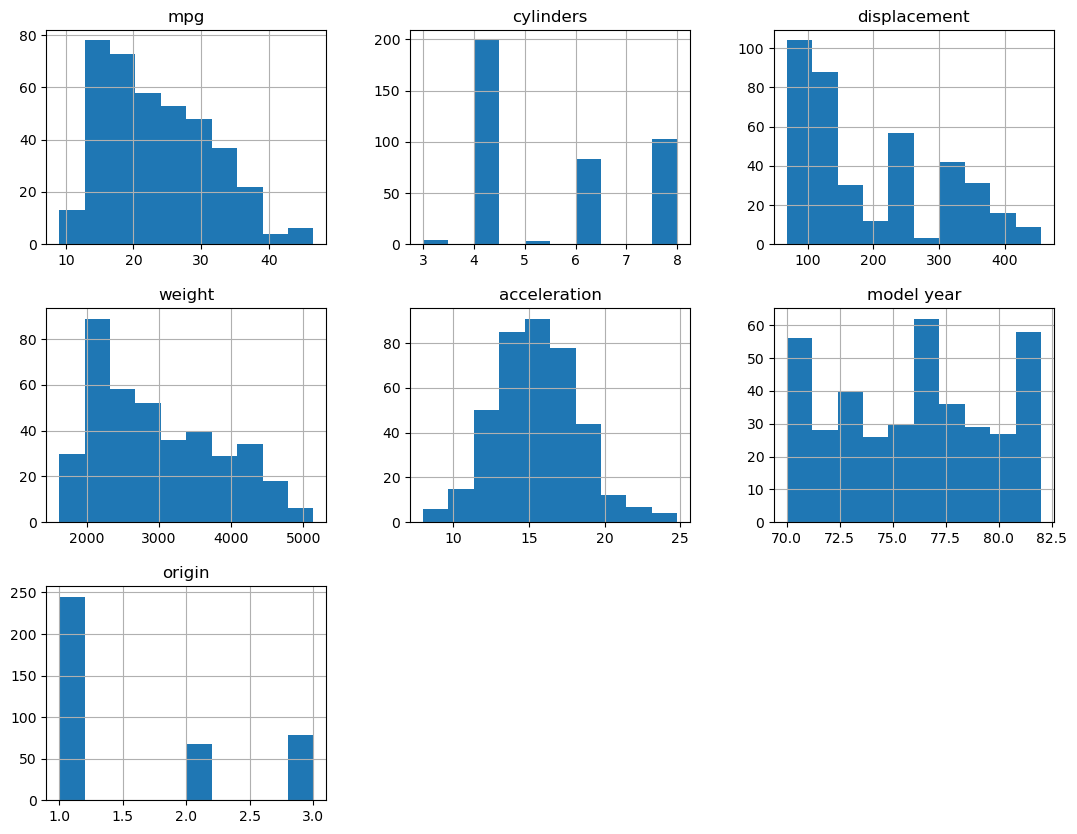

In [52]:
mpgDF.hist(figsize = (13, 10))
plt.show()

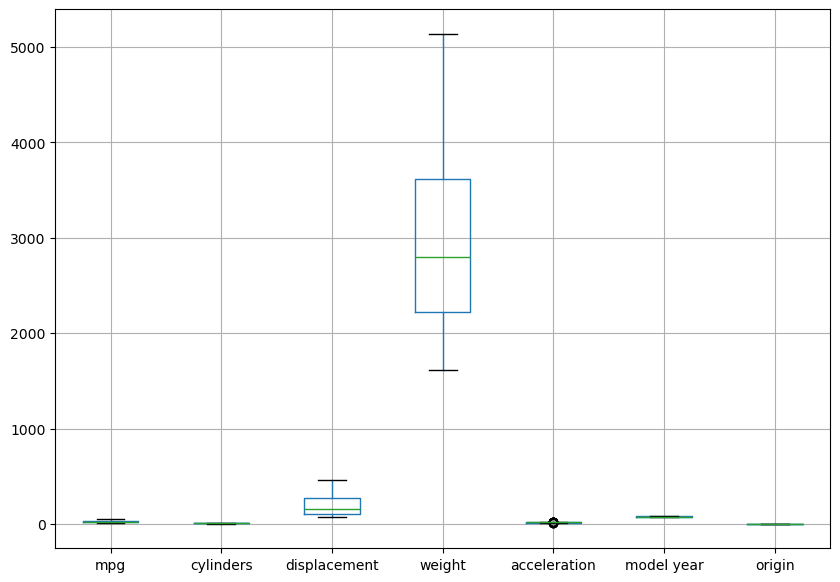

In [53]:
mpgDF.boxplot(figsize = (10, 7))
plt.show()

In [54]:
# 'horsepower' 특성 데이터 타입 정수로 변경
mpgDF['horsepower'] = mpgDF['horsepower'].astype('int64')

In [55]:
# Z-score 기반 이상치 탐지 함수
def find_outlier(column_list, scale = 3, df = mpgDF):
    for col in column_list:
        mean_value = df[col].mean()
        std_value = df[col].std()
        
        base = scale
        z_data = (df[col] - mean_value) / std_value
        mask = z_data.abs() > base
        print(f'{col} 특성의 이상치 개수 : {z_data[mask].count()}개\n')

In [56]:
find_outlier(['displacement', 'horsepower', 'weight', 'acceleration'])

displacement 특성의 이상치 개수 : 0개
horsepower 특성의 이상치 개수 : 0개
weight 특성의 이상치 개수 : 0개
acceleration 특성의 이상치 개수 : 0개


In [57]:
def print_feature(nrows, ncols, df, target, features, corrs):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

In [58]:
mpgDF.corr(numeric_only = True)

mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.777618     -0.805127   -0.778427 -0.832244   
cylinders    -0.777618   1.000000      0.950823    0.842983  0.897527   
displacement -0.805127   0.950823      1.000000    0.897257  0.932994   
horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
weight       -0.832244   0.897527      0.932994    0.864538  1.000000   
acceleration  0.423329  -0.504683     -0.543800   -0.689196 -0.416839   
model year    0.580541  -0.345647     -0.369855   -0.416361 -0.309120   
origin        0.565209  -0.568932     -0.614535   -0.455171 -0.585005   

              acceleration  model year    origin  
mpg               0.423329    0.580541  0.565209  
cylinders        -0.504683   -0.345647 -0.568932  
displacement     -0.543800   -0.369855 -0.614535  
horsepower       -0.689196   -0.416361 -0.455171  
weight           -0.416839   -0.309120 -0.585005  
acceleration      1.000000    0.290316  0.212746  
model year        0.290316    1.000000  0.181528  
origin            0.212746    0.181528  1.000000

In [59]:
corrList = mpgDF.corr(numeric_only = True)['mpg'].to_list()
corrList[1:]

[-0.7776175081260227,
 -0.8051269467104577,
 -0.7784267838977761,
 -0.832244214831575,
 0.42332853690278693,
 0.5805409660907859,
 0.5652087567164604]

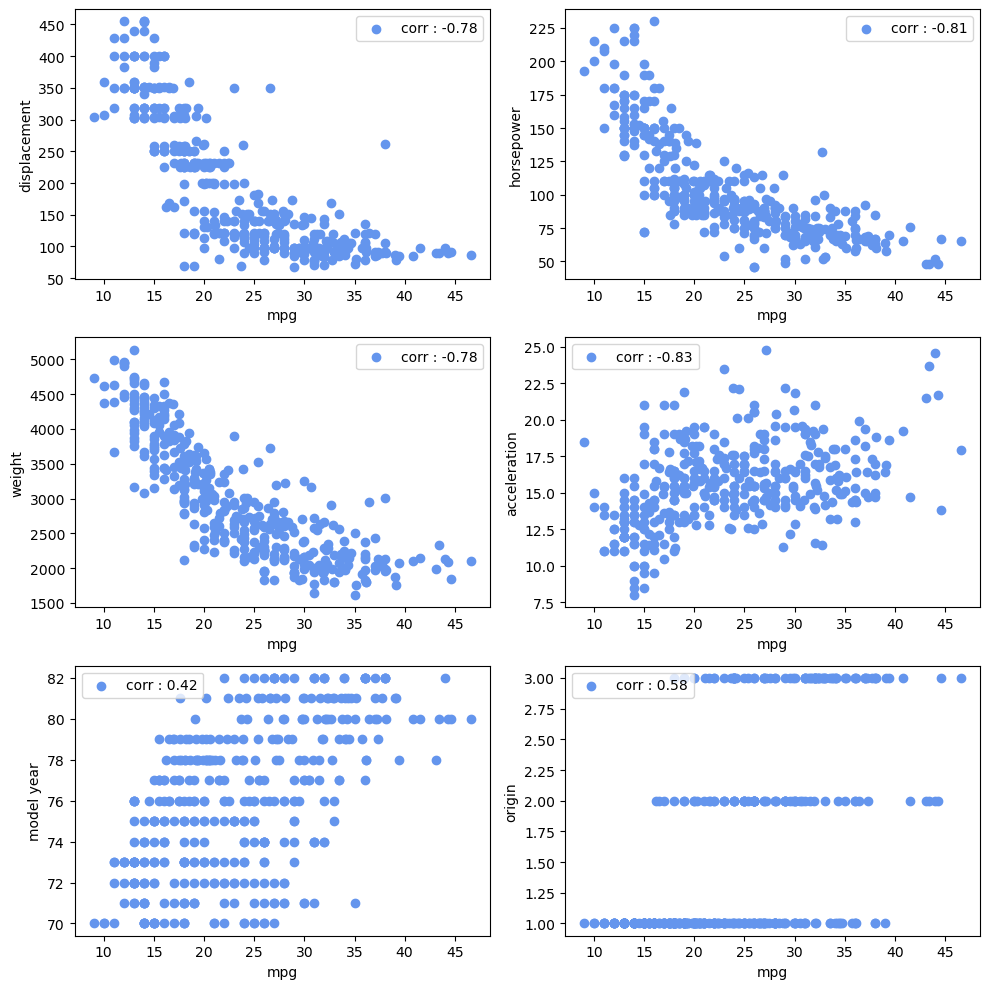

In [60]:
plt.figure(figsize = (10, 10))
print_feature(3, 2, mpgDF, 'mpg', mpgDF.columns[2:], corrList[1:])

In [61]:
mpgDF['cylinders'].value_counts()

cylinders
4    199
8    103
6     83
3      4
5      3
Name: count, dtype: int64

In [62]:
mpgDF['cylinders'].unique()

array([8, 4, 6, 3, 5], dtype=int64)

In [63]:
mpgDF['model year'].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], dtype=int64)

### LinearRegression <hr>

- 'car name'을 제외한 전체 특성을 이용하여 'mpg' 예측

In [64]:
featureDF = mpgDF[mpgDF.columns[2:]]
targetDF = mpgDF['mpg']

In [65]:
for col in featureDF.columns:
    print(f"{col} 특성의 고유값 개수는 {featureDF[col].nunique()}개\n")

displacement 특성의 고유값 개수는 81개

horsepower 특성의 고유값 개수는 93개

weight 특성의 고유값 개수는 346개

acceleration 특성의 고유값 개수는 95개

model year 특성의 고유값 개수는 13개

origin 특성의 고유값 개수는 3개



In [66]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = 0.2, random_state = 42)

In [67]:
featureDF.columns

Index(['displacement', 'horsepower', 'weight', 'acceleration', 'model year',
       'origin'],
      dtype='object')

In [68]:
ct = ColumnTransformer([('scaling', RobustScaler(), ['displacement', 'horsepower', 'weight', 'acceleration']), ('onehot', OneHotEncoder(sparse = False), ['model year' , 'origin'])])
ct.fit(X_train)
scaled_X_train = ct.transform(X_train)
scaled_X_test = ct.transform(X_test)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [69]:
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_test, y_test)

0.8366988993534501

- car name을 제외한 상관계수가 높은 'displacement', 'horsepower', 'weight' 특성과 범주형 특성 'model year', 'origin'이용하여 'mpg' 예측

In [70]:
mpgDF.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin'],
      dtype='object')

In [71]:
featureDF = mpgDF[['displacement', 'horsepower', 'weight', 'model year', 'origin']]
targetDF = mpgDF['mpg']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = 0.2, random_state = 42)

In [73]:
ct = ColumnTransformer([('scaling', StandardScaler(), ['displacement', 'horsepower', 'weight']), ('onehot', OneHotEncoder(sparse = False), ['model year' , 'origin'])])
ct.fit(X_train)
scaled_X_train = ct.transform(X_train)
scaled_X_test = ct.transform(X_test)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [74]:
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.8561430103054943, 0.8362258139372697)

- car name을 제외한 상관계수가 높은 'displacement', 'horsepower', 'weight' 이용하여 'mpg' 예측

In [75]:
featureDF = mpgDF[['displacement', 'horsepower', 'weight']]
targetDF = mpgDF['mpg']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = 0.2, random_state = 42)

In [77]:
scaler = RobustScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [78]:
model = LinearRegression()
model.fit(scaled_X_train, y_train)
model.score(scaled_X_train, y_train), model.score(scaled_X_test, y_test)

(0.7163466600205473, 0.6470668946730962)

### PolynomialFeatures <hr>

- car name을 제외한 상관계수가 높은 'displacement', 'horsepower', 'weight' 특성과 범주형 특성 'model year', 'origin'이용하여 'mpg' 예측

In [79]:
mpgDF

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0    18.0          8         307.0         130    3504          12.0   
1    15.0          8         350.0         165    3693          11.5   
2    18.0          8         318.0         150    3436          11.0   
3    16.0          8         304.0         150    3433          12.0   
4    17.0          8         302.0         140    3449          10.5   
..    ...        ...           ...         ...     ...           ...   
387  27.0          4         140.0          86    2790          15.6   
388  44.0          4          97.0          52    2130          24.6   
389  32.0          4         135.0          84    2295          11.6   
390  28.0          4         120.0          79    2625          18.6   
391  31.0          4         119.0          82    2720          19.4   

     model year  origin  
0            70       1  
1            70       1  
2            70       1  
3            70       1  
4            70       1  
..          ...     ...  
387          82       1  
388          82       2  
389          82       1  
390          82       1  
391          82       1  

[392 rows x 8 columns]

In [80]:
df = mpgDF
target = 'mpg'
feature = ['displacement', 'horsepower', 'weight']
poly = PolynomialFeatures(include_bias = False, degree = 2)
poly.fit(df[feature])  # fit에 넣을 데이터는 2차원이어야 한다.
poly_data = poly.transform(df[feature])
poly_data.shape
df[['model year', 'origin']].shape
poly_feature_names = poly.get_feature_names_out(feature)
new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
new_df = pd.concat([new_df, df[['model year', 'origin']]], axis = 1)
new_df = pd.concat([new_df, df[target]], axis = 1)
featureDF = new_df[new_df.columns[:-1]]
targetDF = new_df[target] 
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = 0.2, random_state = 42)

ct = ColumnTransformer([('scaling', StandardScaler(), new_df.columns[:-3]), ('onehot', OneHotEncoder(sparse = False), ['model year' , 'origin'])])
ct.fit(X_train)
scaled_X_train = ct.transform(X_train)
scaled_X_test = ct.transform(X_test)
pd.DataFrame(scaled_X_train)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0         1         2         3         4         5         6   \
0    0.284578  0.141429  0.754803  0.034364  0.035833  0.291766 -0.031136   
1   -0.535880 -0.329499 -0.493129 -0.606053 -0.521021 -0.592256 -0.407355   
2   -0.236655 -0.198685 -0.002530 -0.407043 -0.347116 -0.300090 -0.309575   
3    1.182255  1.187934  1.368052  1.076763  1.112478  1.265296  1.044958   
4   -1.057113 -1.062052 -1.323099 -0.857967 -0.867049 -0.979057 -0.859314   
..        ...       ...       ...       ...       ...       ...       ...   
308  1.047121  1.187934  1.078694  0.897013  1.013962  1.008968  1.044958   
309  0.352145 -0.120198 -0.234731  0.100398 -0.036882 -0.033993 -0.248424   
310 -0.429703 -0.512637 -0.156140 -0.539978 -0.523132 -0.454085 -0.535554   
311 -0.941283 -1.035889 -0.721758 -0.812390 -0.826422 -0.839009 -0.845966   
312  1.973756  1.187934  2.394500  2.292079  1.689504  2.595687  1.044958   

           7         8    9   ...   15   16   17   18   19   20   21   22  \
0    0.270156  0.646475  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
1   -0.477464 -0.558251  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2   -0.233045 -0.133284  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3    1.297592  1.387930  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4   -1.017089 -1.133686  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
..        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
308  1.128936  1.025807  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
309 -0.281851 -0.342277  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
310 -0.449466 -0.273122  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
311 -0.856531 -0.734765  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
312  1.895870  2.849330  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

      23   24  
0    0.0  0.0  
1    0.0  0.0  
2    0.0  0.0  
3    0.0  0.0  
4    0.0  0.0  
..   ...  ...  
308  0.0  0.0  
309  0.0  0.0  
310  0.0  0.0  
311  0.0  0.0  
312  0.0  0.0  

[313 rows x 25 columns]

In [81]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, my_model = LinearRegression(), df = mpgDF, test_size = 0.2, random_state = 42):
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(df[feature])  # fit에 넣을 데이터는 2차원이어야 한다.
    poly_data = poly.transform(df[feature])
    poly_feature_names = poly.get_feature_names_out(feature)
    new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    new_df = pd.concat([new_df, df[['model year', 'origin']]], axis = 1)
    new_df = pd.concat([new_df, df[target]], axis = 1)
    featureDF = new_df[new_df.columns[:-1]]
    targetDF = new_df[target] 
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = test_size, random_state = random_state)
    ct = ColumnTransformer([('scaling', my_scaler, new_df.columns[:-3]), ('onehot', OneHotEncoder(sparse = False), ['model year' , 'origin'])], remainder = 'passthrough')
    ct.fit(X_train)
    scaled_X_train = ct.transform(X_train)
    scaled_X_test = ct.transform(X_test)

    my_model.fit(scaled_X_train, y_train)
    return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

In [82]:
score_return(['displacement', 'horsepower', 'weight'], 'mpg', StandardScaler(), 2)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(0.89, 0.88)

In [83]:
def main(start_degree, end_degree):
    degree_list = list(range(start_degree, end_degree + 1))
    for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
        for degree in degree_list:
            train_score = score_return(['displacement', 'horsepower', 'weight'], 'mpg', scaler, degree)[0]
            test_score = score_return(['displacement', 'horsepower', 'weight'], 'mpg', scaler, degree)[1]
            print(f'degree가 {degree}일 때 ===>\n')
            print(f'{scaler} => Train Score : {train_score} --- Test Score : {test_score}\n')

main(2, 6)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in 

degree가 2일 때 ===>

StandardScaler() => Train Score : 0.89 --- Test Score : 0.88

degree가 3일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.89

degree가 4일 때 ===>

StandardScaler() => Train Score : 0.91 --- Test Score : 0.88

degree가 5일 때 ===>

StandardScaler() => Train Score : 0.92 --- Test Score : 0.88

degree가 6일 때 ===>

StandardScaler() => Train Score : 0.93 --- Test Score : 0.36

degree가 2일 때 ===>

MinMaxScaler() => Train Score : 0.89 --- Test Score : 0.88



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in 

degree가 3일 때 ===>

MinMaxScaler() => Train Score : 0.9 --- Test Score : 0.89

degree가 4일 때 ===>

MinMaxScaler() => Train Score : 0.91 --- Test Score : 0.88

degree가 5일 때 ===>

MinMaxScaler() => Train Score : 0.92 --- Test Score : 0.88

degree가 6일 때 ===>

MinMaxScaler() => Train Score : 0.93 --- Test Score : 0.36

degree가 2일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.88

degree가 3일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.89

degree가 4일 때 ===>

RobustScaler() => Train Score : 0.91 --- Test Score : 0.88

degree가 5일 때 ===>

RobustScaler() => Train Score : 0.92 --- Test Score : 0.88

degree가 6일 때 ===>

RobustScaler() => Train Score : 0.93 --- Test Score : 0.36



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in 

- car name을 제외한 상관계수가 높은 'displacement', 'horsepower', 'weight' 특성과 범주형 특성 'model year', 'origin', 'cylinder'를 이용하여 'mpg' 예측

In [84]:
mpgDF['cylinders'].value_counts()

cylinders
4    199
8    103
6     83
3      4
5      3
Name: count, dtype: int64

In [85]:
# cylinder값이 3 또는 5인 데이터 삭제
mpgDF2 = mpgDF[mpgDF['cylinders'].isin([4, 6, 8])]
mpgDF2.reset_index(drop = True, inplace = True)

In [86]:
mpgDF2.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin'],
      dtype='object')

In [87]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, my_model = LinearRegression(), df = mpgDF2, test_size = 0.2, random_state = 42):
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(df[feature])  # fit에 넣을 데이터는 2차원이어야 한다.
    poly_data = poly.transform(df[feature])
    poly_feature_names = poly.get_feature_names_out(feature)
    new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    new_df = pd.concat([new_df, df[['cylinders', 'model year', 'origin']]], axis = 1)
    new_df = pd.concat([new_df, df[target]], axis = 1)
    featureDF = new_df[new_df.columns[:-1]]
    targetDF = new_df[target] 
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = test_size, random_state = random_state)
    ct = ColumnTransformer([('scaling', my_scaler, new_df.columns[:-3]), ('onehot', OneHotEncoder(sparse = False), ['model year' , 'origin', 'cylinders'])], remainder = 'passthrough')
    ct.fit(X_train)
    scaled_X_train = ct.transform(X_train)
    scaled_X_test = ct.transform(X_test)

    my_model.fit(scaled_X_train, y_train)
    return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

In [88]:
# LinearRegression 학습
def main(start_degree, end_degree):
    degree_list = list(range(start_degree, end_degree + 1))
    for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
        for degree in degree_list:
            train_score = score_return(['displacement', 'horsepower', 'weight'], 'mpg', scaler, degree)[0]
            test_score = score_return(['displacement', 'horsepower', 'weight'], 'mpg', scaler, degree)[1]
            print(f'degree가 {degree}일 때 ===>\n')
            print(f'{scaler} => Train Score : {train_score} --- Test Score : {test_score}\n')

main(2, 6)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in 

degree가 2일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.9

degree가 3일 때 ===>

StandardScaler() => Train Score : 0.91 --- Test Score : 0.89

degree가 4일 때 ===>

StandardScaler() => Train Score : 0.91 --- Test Score : 0.85

degree가 5일 때 ===>

StandardScaler() => Train Score : 0.92 --- Test Score : 0.68

degree가 6일 때 ===>

StandardScaler() => Train Score : 0.93 --- Test Score : -3.2

degree가 2일 때 ===>

MinMaxScaler() => Train Score : 0.9 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in 

degree가 3일 때 ===>

MinMaxScaler() => Train Score : 0.91 --- Test Score : 0.89

degree가 4일 때 ===>

MinMaxScaler() => Train Score : 0.91 --- Test Score : 0.85

degree가 5일 때 ===>

MinMaxScaler() => Train Score : 0.92 --- Test Score : 0.68

degree가 6일 때 ===>

MinMaxScaler() => Train Score : 0.93 --- Test Score : -3.2

degree가 2일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.9

degree가 3일 때 ===>

RobustScaler() => Train Score : 0.91 --- Test Score : 0.89

degree가 4일 때 ===>

RobustScaler() => Train Score : 0.91 --- Test Score : 0.85

degree가 5일 때 ===>

RobustScaler() => Train Score : 0.92 --- Test Score : 0.68

degree가 6일 때 ===>

RobustScaler() => Train Score : 0.93 --- Test Score : -3.2



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in 

In [89]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, max_k, weights = 'uniform', metric = 'minkowski', my_model = LinearRegression(), df = mpgDF2, test_size = 0.2, random_state = 42):
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(df[feature])  # fit에 넣을 데이터는 2차원이어야 한다.
    poly_data = poly.transform(df[feature])
    poly_feature_names = poly.get_feature_names_out(feature)
    new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    new_df = pd.concat([new_df, df[['cylinders', 'model year', 'origin']]], axis = 1)
    new_df = pd.concat([new_df, df[target]], axis = 1)
    featureDF = new_df[new_df.columns[:-1]]
    targetDF = new_df[target] 
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = test_size, random_state = random_state)
    ct = ColumnTransformer([('scaling', my_scaler, new_df.columns[:-3]), ('onehot', OneHotEncoder(sparse = False), ['model year' , 'origin', 'cylinders'])], remainder = 'passthrough')
    ct.fit(X_train)
    scaled_X_train = ct.transform(X_train)
    scaled_X_test = ct.transform(X_test)

    if my_model.__class__ == KNeighborsRegressor:
        train_scoreList = []
        test_scoreList = []
        for k in range(1, max_k + 1):
            model = KNeighborsRegressor(n_neighbors = k)
            model.fit(scaled_X_train, y_train)
            train_scoreList.append(model.score(scaled_X_train, y_train))
            test_scoreList.append(model.score(scaled_X_test, y_test))
        
        # k에 따른 학습용/테스트용 점수 시각화
        plt.plot(train_scoreList, 'b--', label = 'Train score')
        plt.plot(test_scoreList, 'r', label = 'Test score')
        plt.title('k & Score')
        plt.xlabel('k')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

        print(f'최적의 이웃 개수 k = {test_scoreList.index(max(test_scoreList))+1}')
        model = KNeighborsRegressor(n_neighbors = test_scoreList.index(max(test_scoreList))+1, weights = weights, metric = metric)
        model.fit(scaled_X_train, y_train)
        return round(model.score(scaled_X_train, y_train), 2), round(model.score(scaled_X_test, y_test), 2)

    else:
        my_model.fit(scaled_X_train, y_train)
        return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


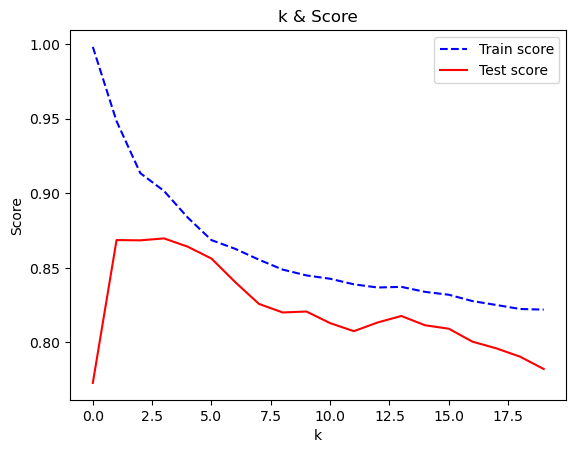

최적의 이웃 개수 k = 4


(1.0, 0.9)

In [90]:
score_return(['displacement', 'horsepower', 'weight'], 'mpg',
             StandardScaler(), 2, 20, weights = 'distance', metric = 'minkowski', my_model = KNeighborsRegressor())

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


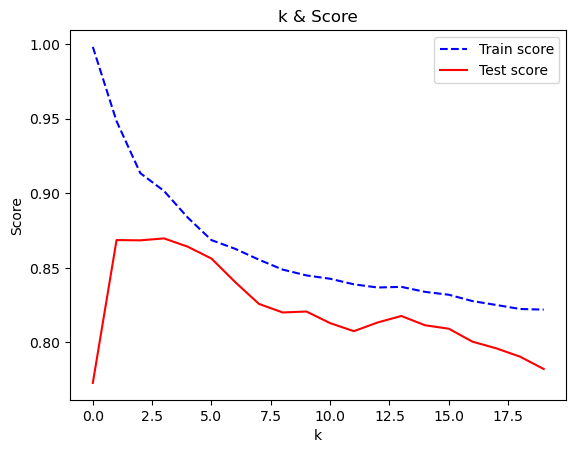

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


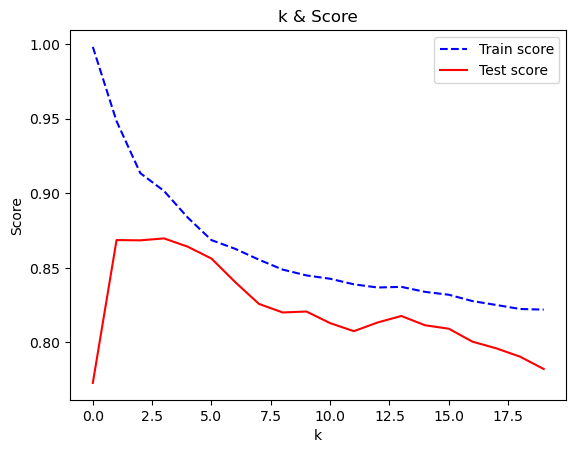

최적의 이웃 개수 k = 4
degree : 2, weight : uniform, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.88



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


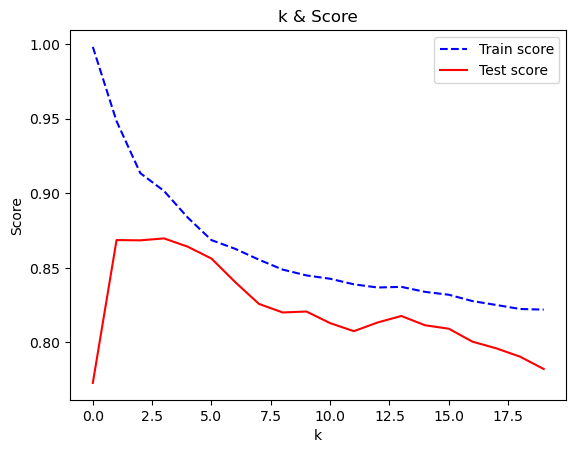

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


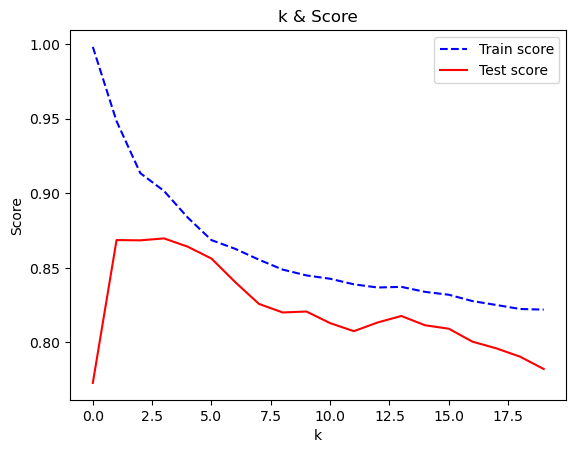

최적의 이웃 개수 k = 4
degree : 2, weight : uniform, metric : cosine일 때 ===>

StandardScaler() => Train Score : 0.88 --- Test Score : 0.84



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


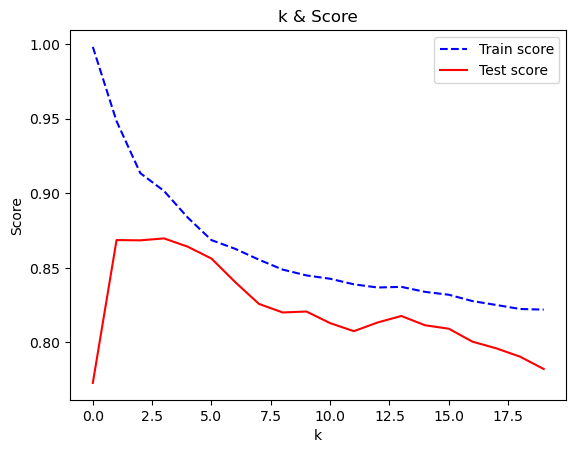

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


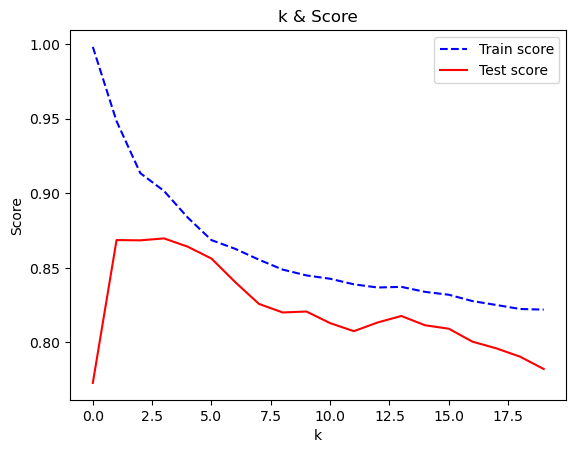

최적의 이웃 개수 k = 4
degree : 2, weight : uniform, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


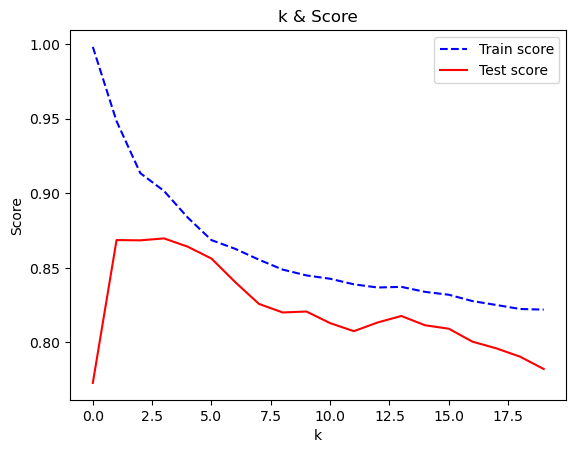

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


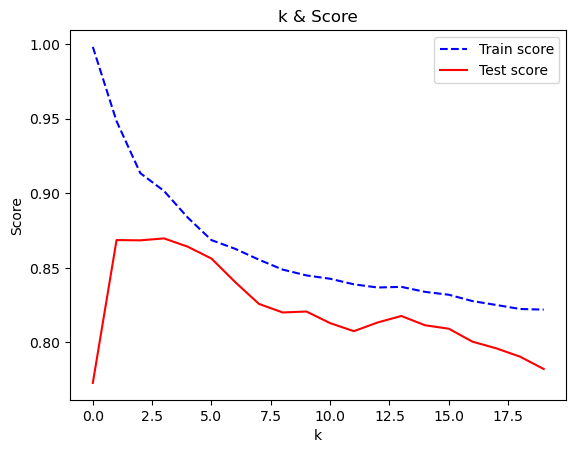

최적의 이웃 개수 k = 4
degree : 2, weight : uniform, metric : l1일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.88



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


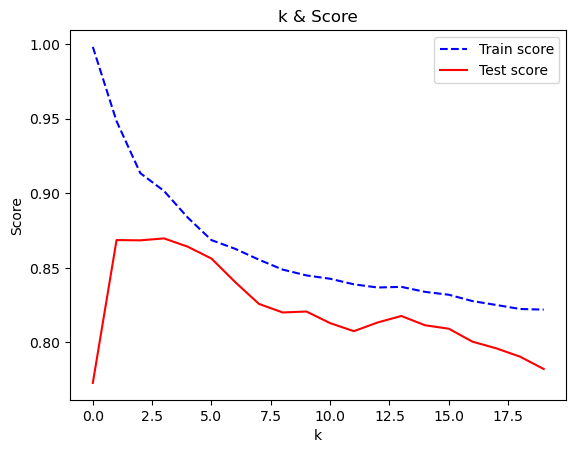

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


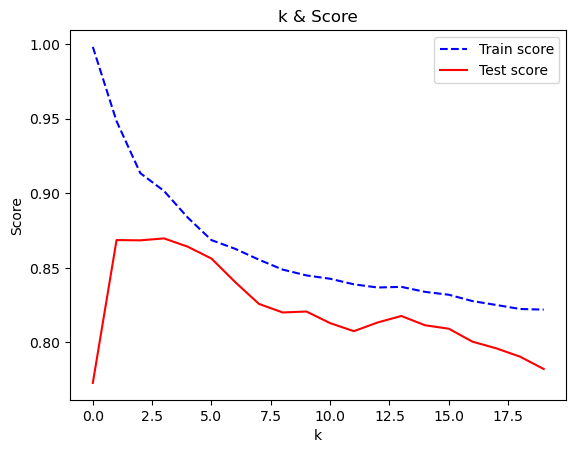

최적의 이웃 개수 k = 4
degree : 2, weight : uniform, metric : l2일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


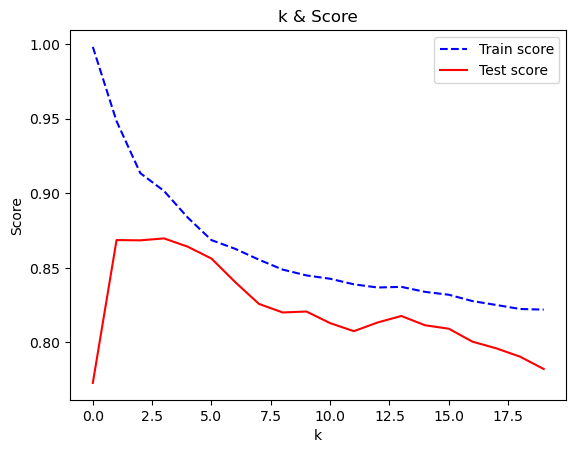

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


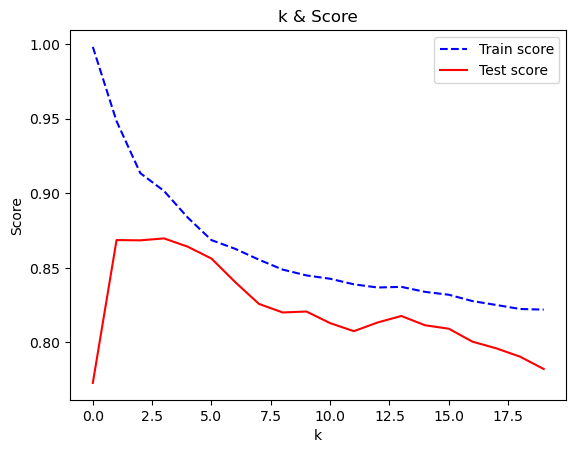

최적의 이웃 개수 k = 4
degree : 2, weight : uniform, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.88



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


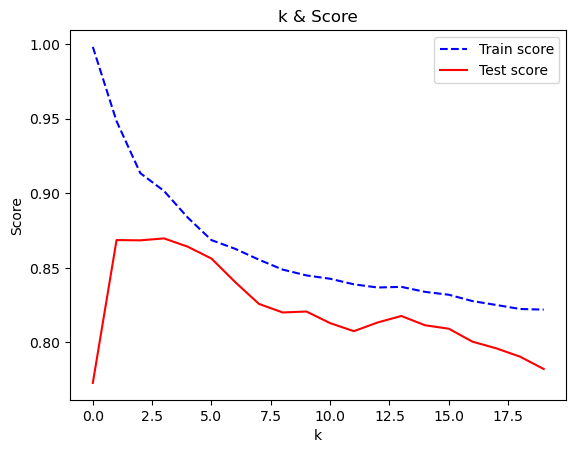

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


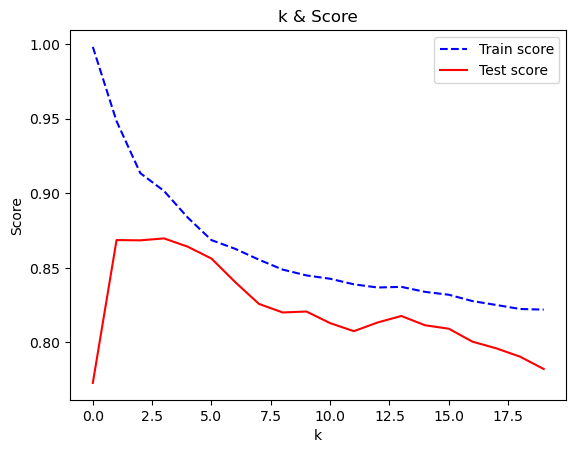

최적의 이웃 개수 k = 4
degree : 2, weight : uniform, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 0.9 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


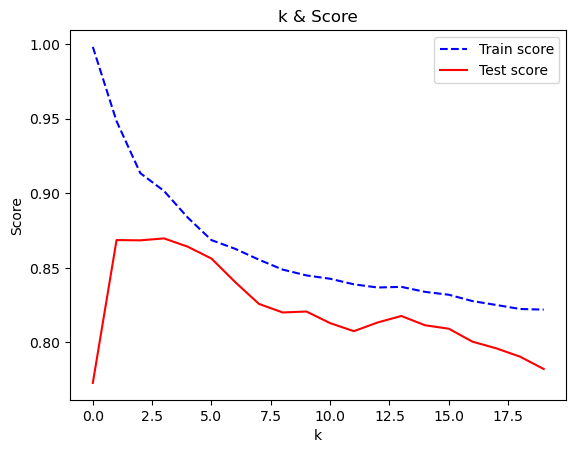

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


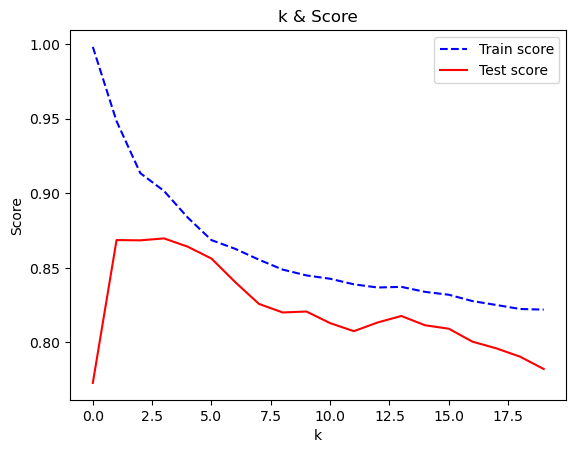

최적의 이웃 개수 k = 4
degree : 2, weight : distance, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


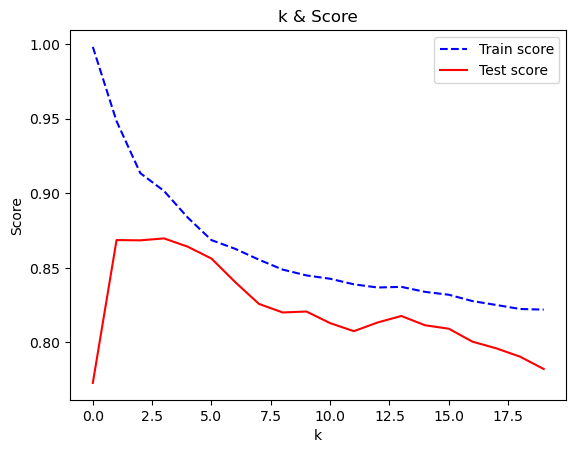

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


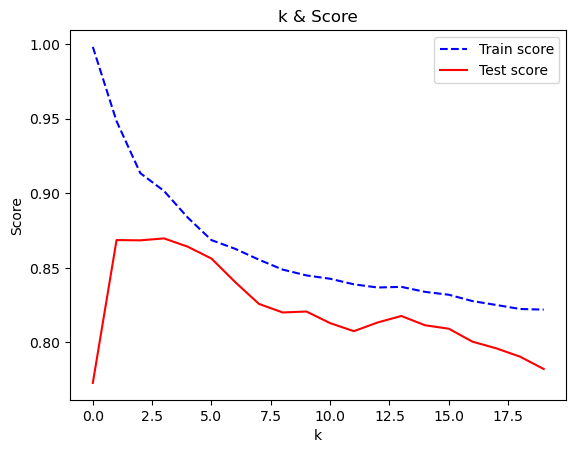

최적의 이웃 개수 k = 4
degree : 2, weight : distance, metric : cosine일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


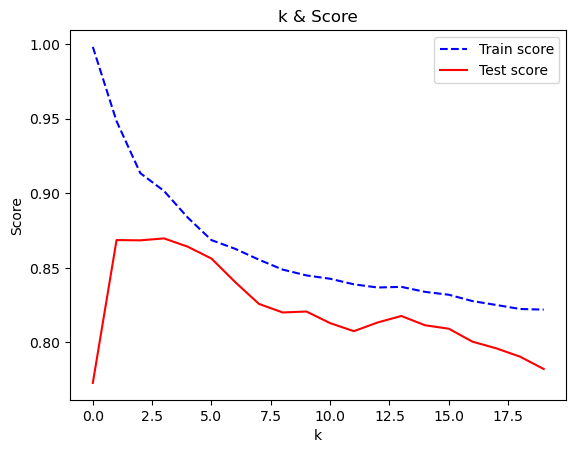

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


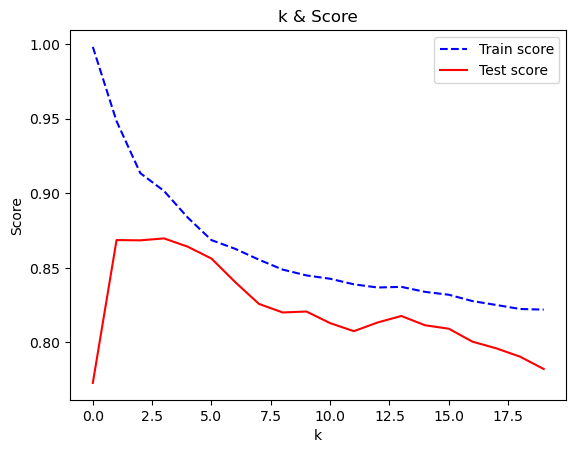

최적의 이웃 개수 k = 4
degree : 2, weight : distance, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


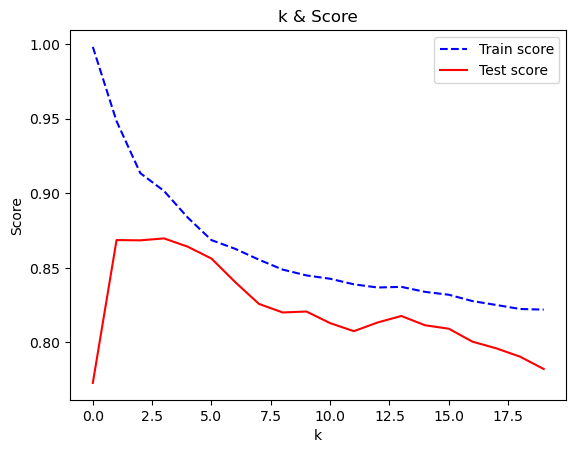

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


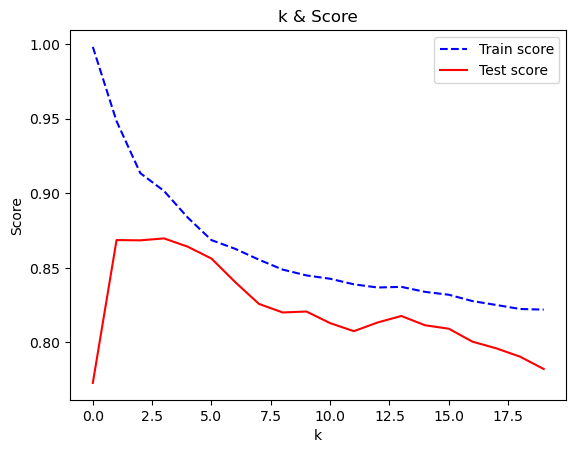

최적의 이웃 개수 k = 4
degree : 2, weight : distance, metric : l1일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


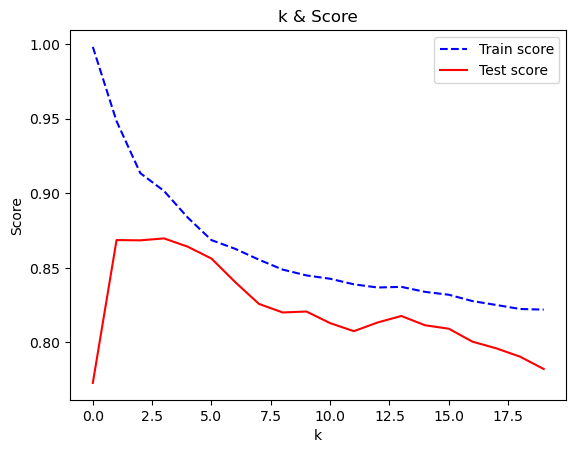

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


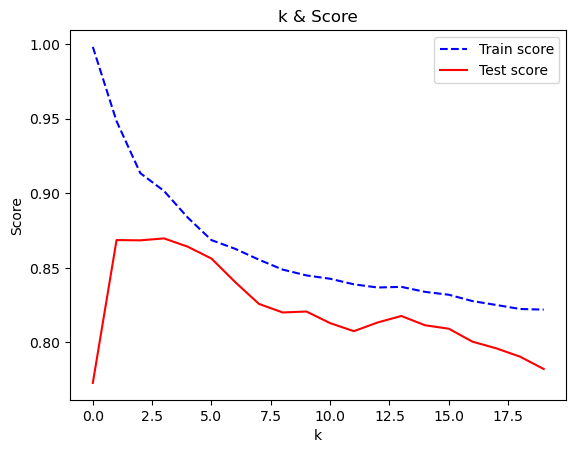

최적의 이웃 개수 k = 4
degree : 2, weight : distance, metric : l2일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


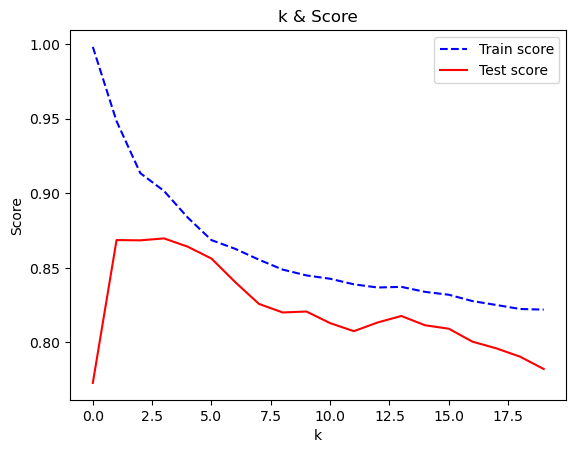

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


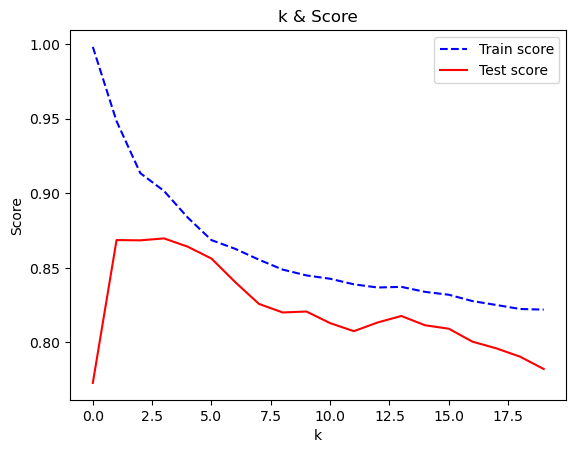

최적의 이웃 개수 k = 4
degree : 2, weight : distance, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


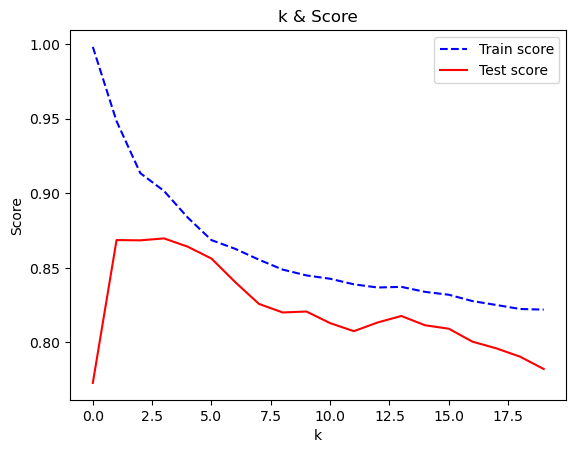

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


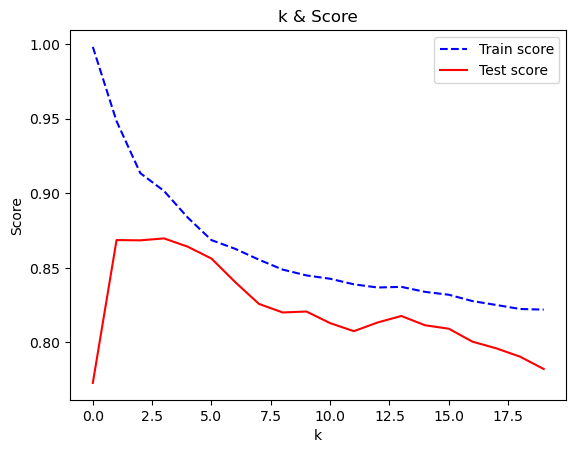

최적의 이웃 개수 k = 4
degree : 2, weight : distance, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


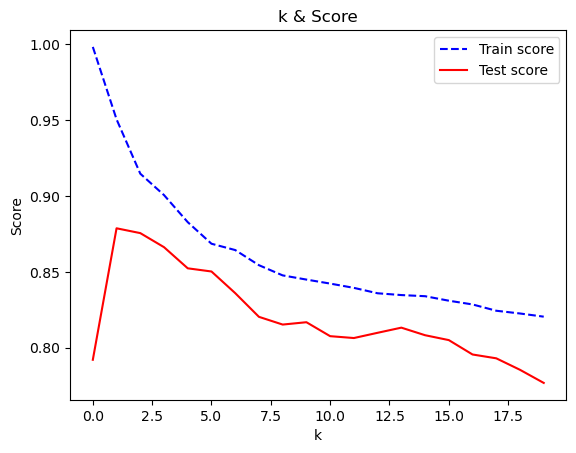

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


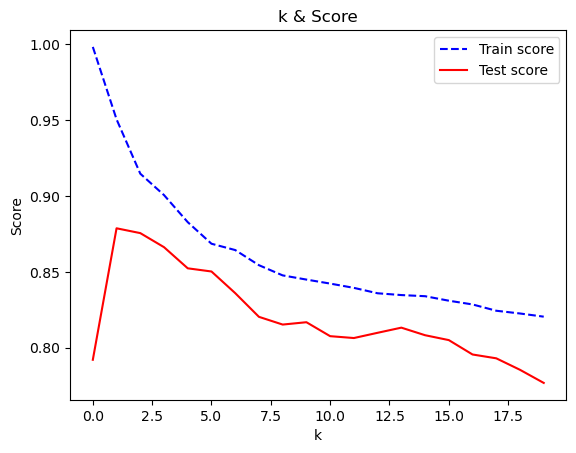

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 0.95 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


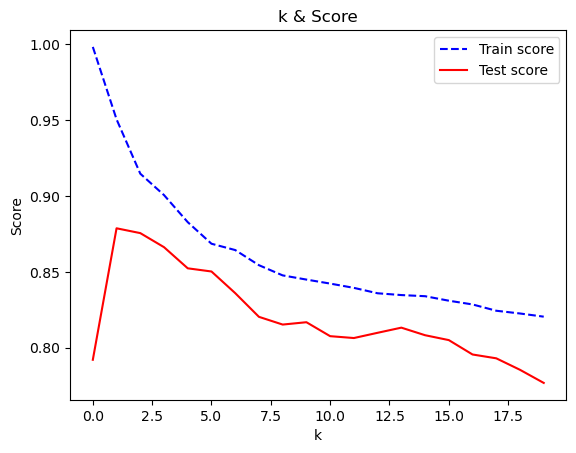

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


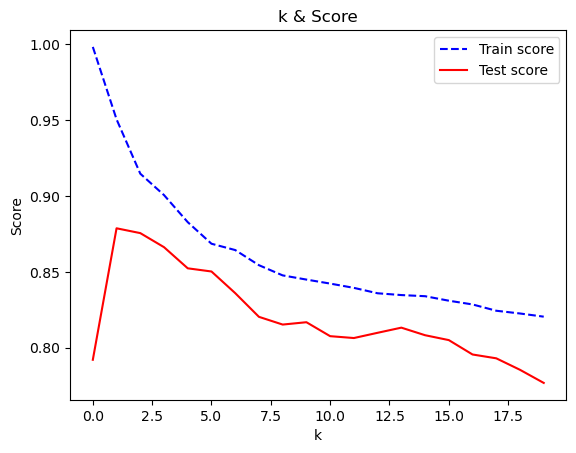

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : cosine일 때 ===>

StandardScaler() => Train Score : 0.95 --- Test Score : 0.85



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


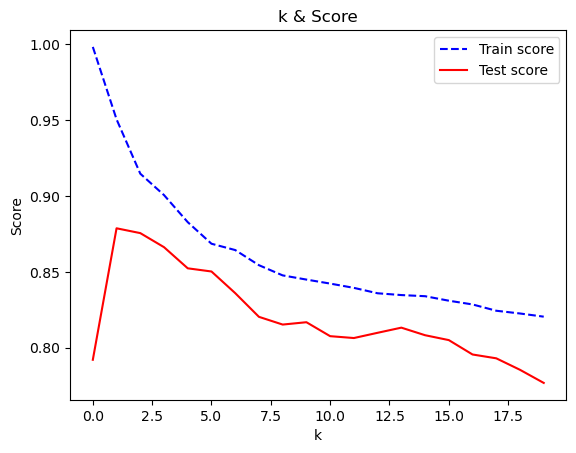

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


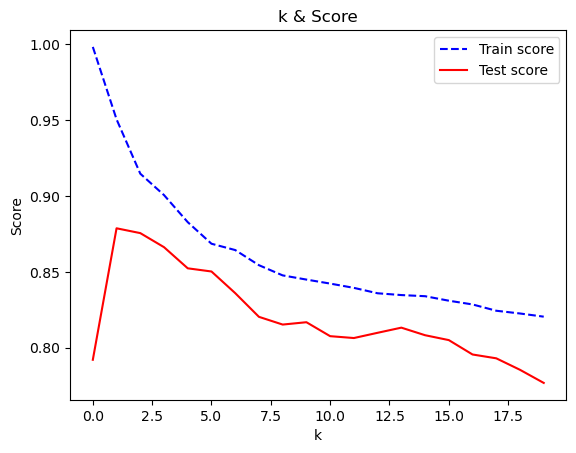

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 0.95 --- Test Score : 0.88



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


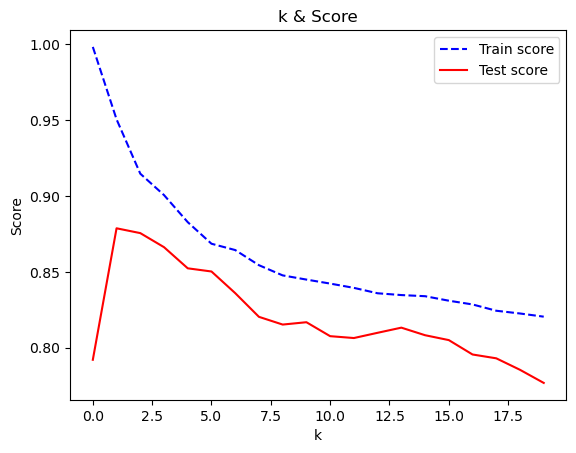

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


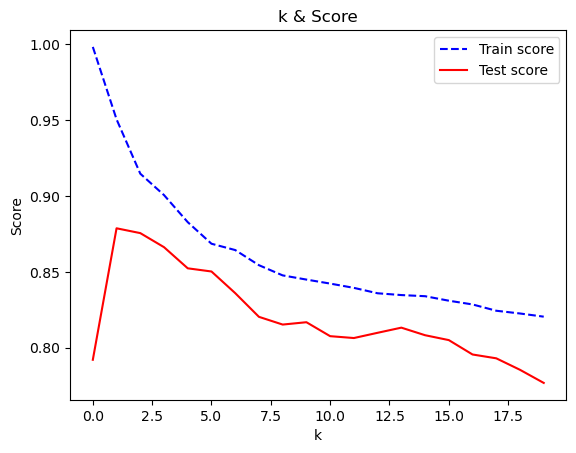

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : l1일 때 ===>

StandardScaler() => Train Score : 0.95 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


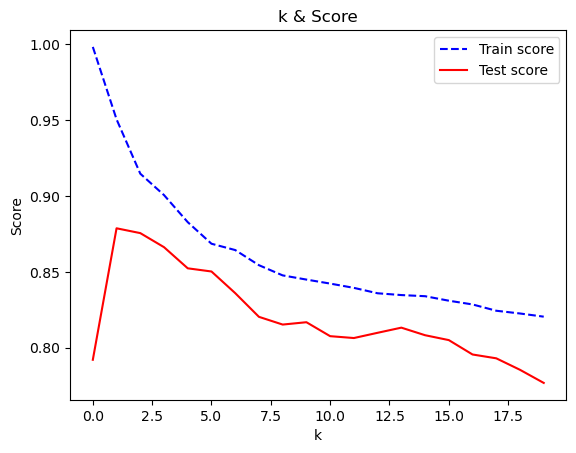

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


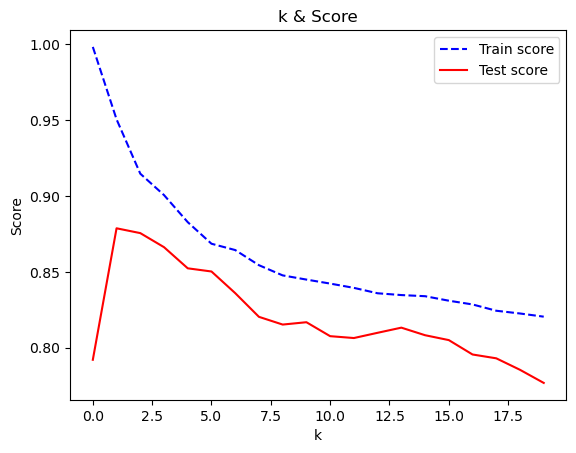

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : l2일 때 ===>

StandardScaler() => Train Score : 0.95 --- Test Score : 0.88



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


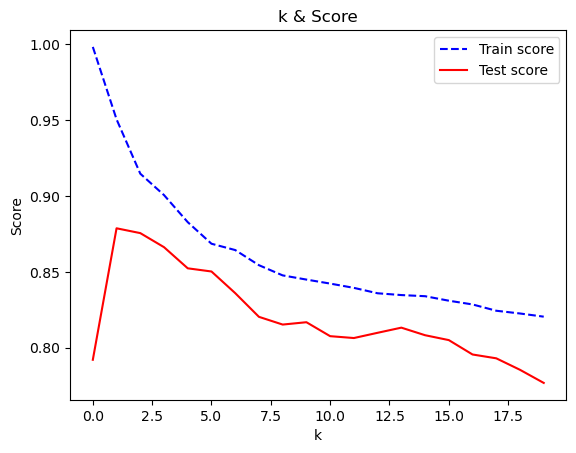

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


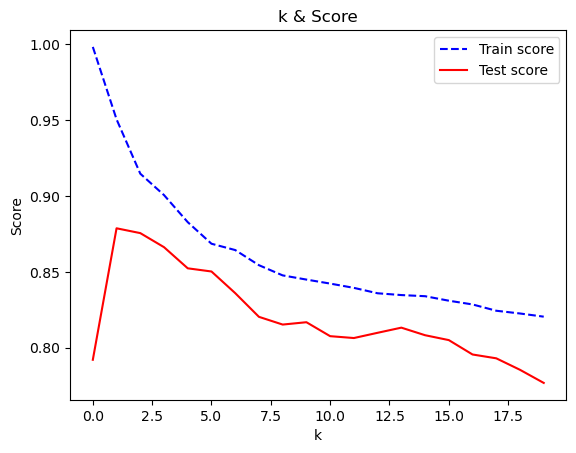

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 0.95 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


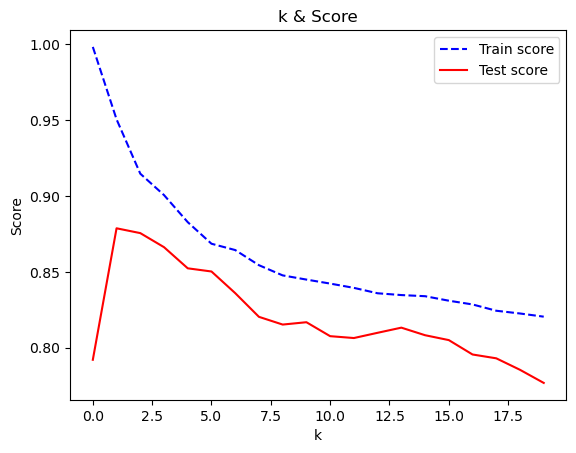

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


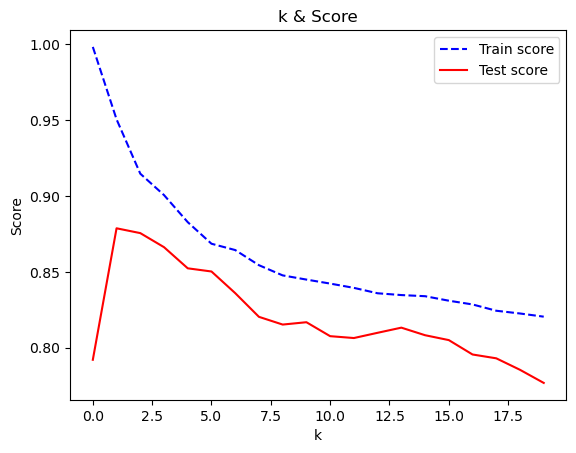

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 0.95 --- Test Score : 0.88



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


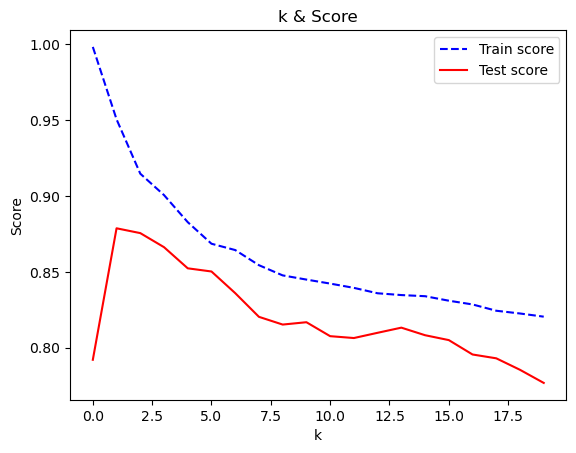

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


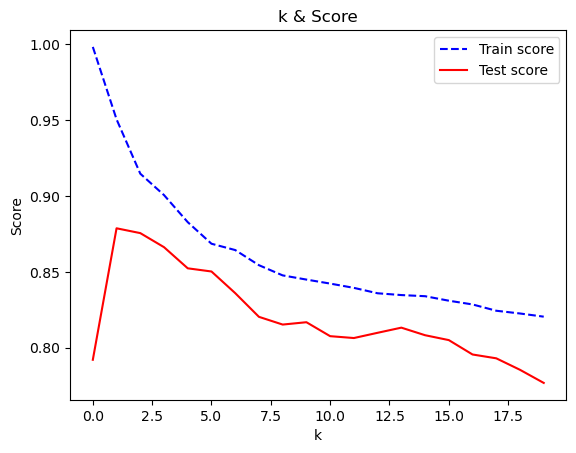

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : cityblock일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.81



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


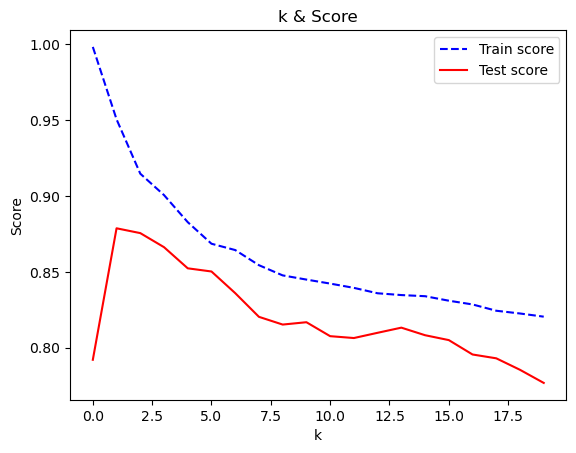

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


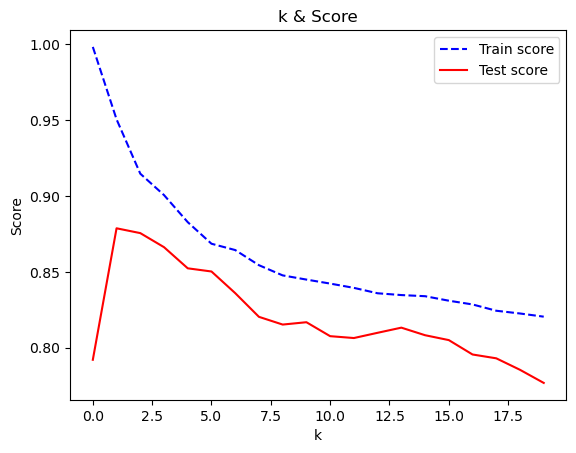

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : cosine일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.84



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


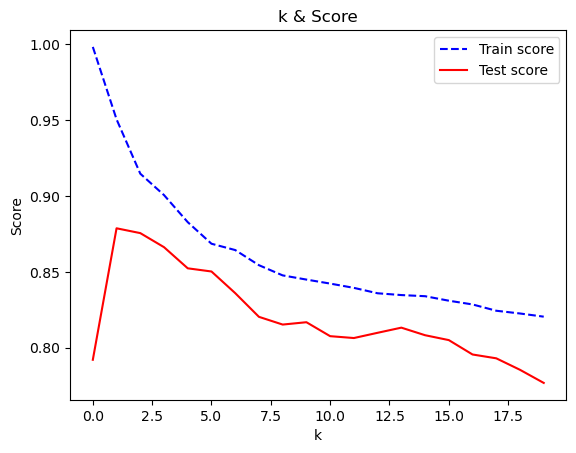

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


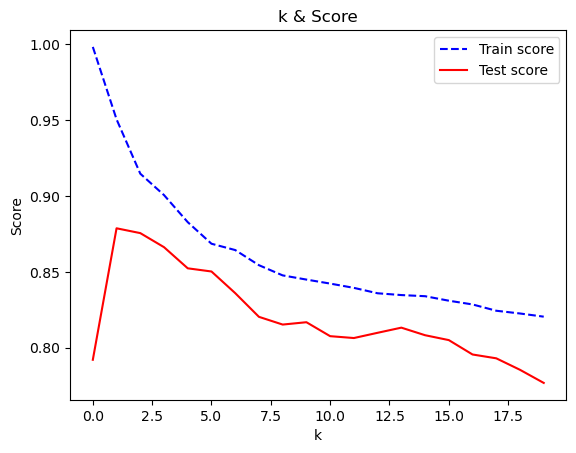

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : euclidean일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


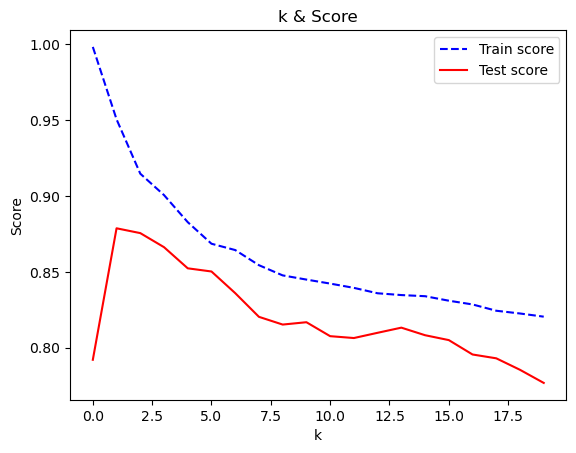

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


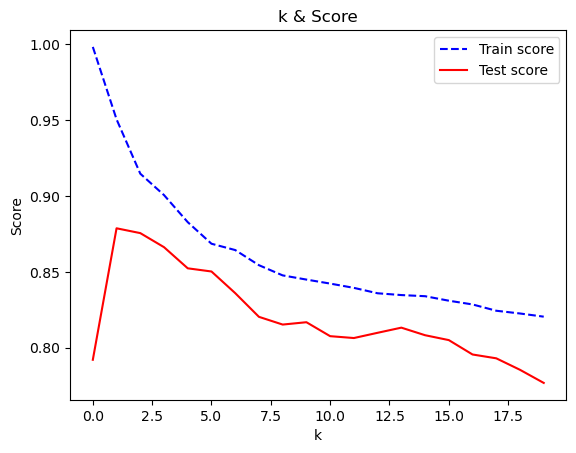

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : l1일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.81



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


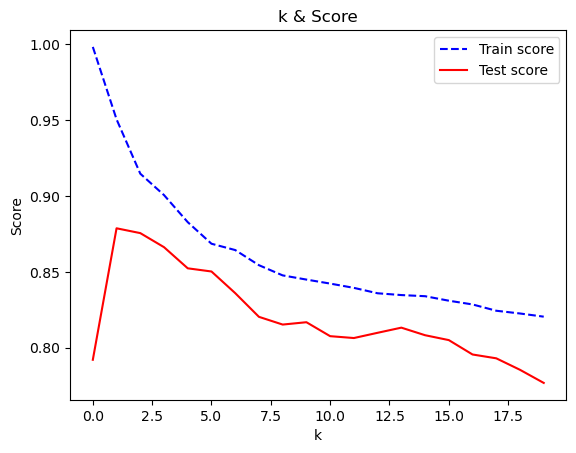

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


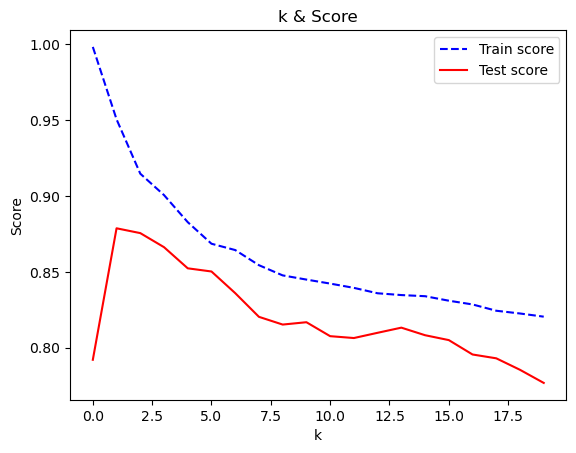

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : l2일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


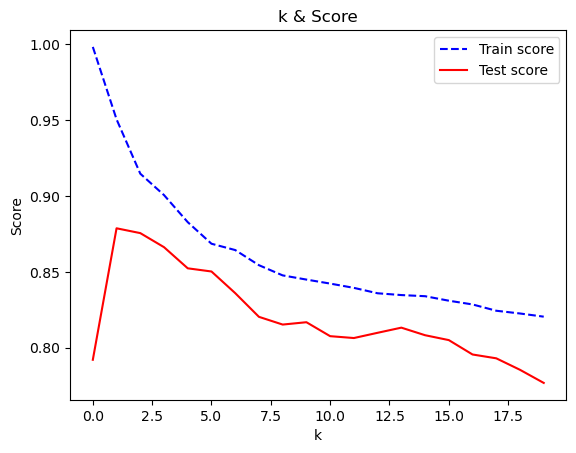

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


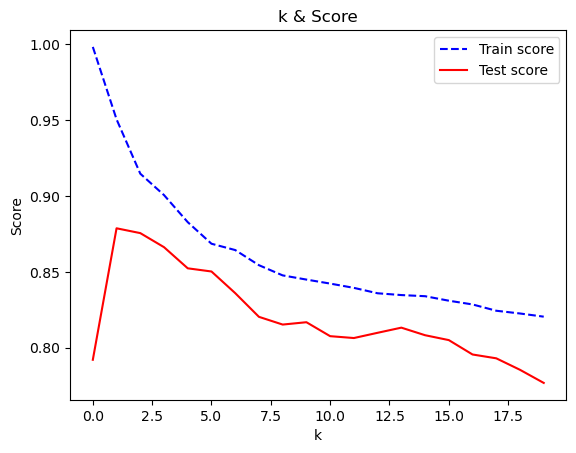

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : manhattan일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.81



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


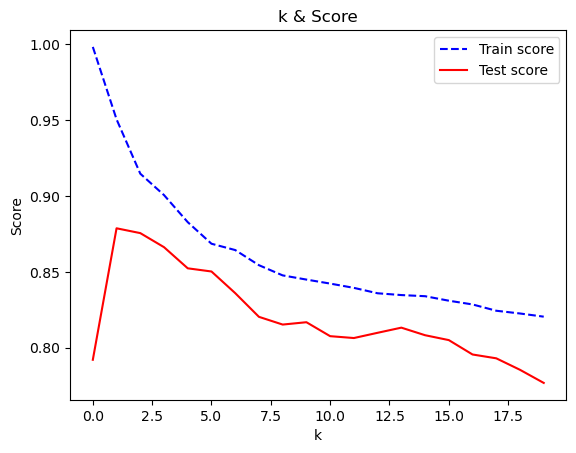

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


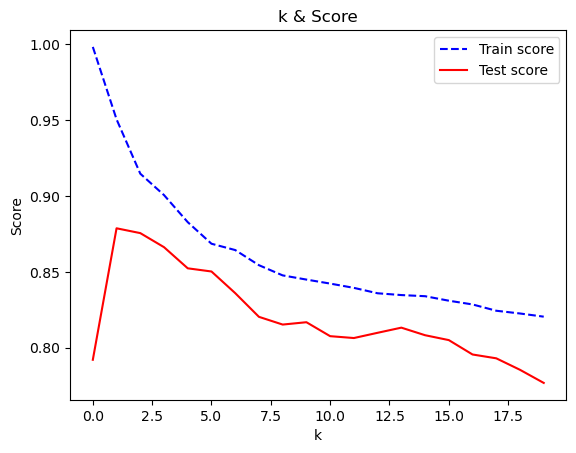

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : nan_euclidean일 때 ===>

StandardScaler() => Train Score : 1.0 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


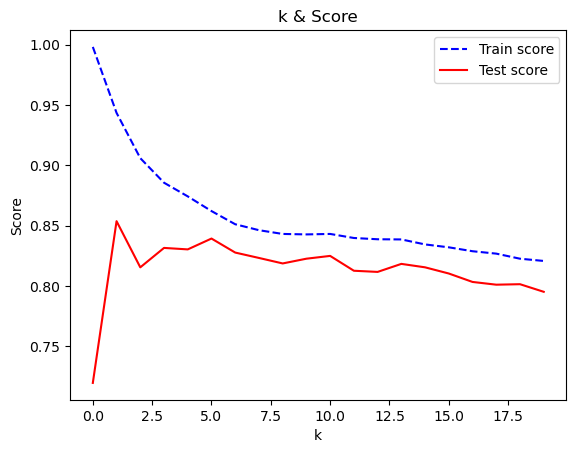

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


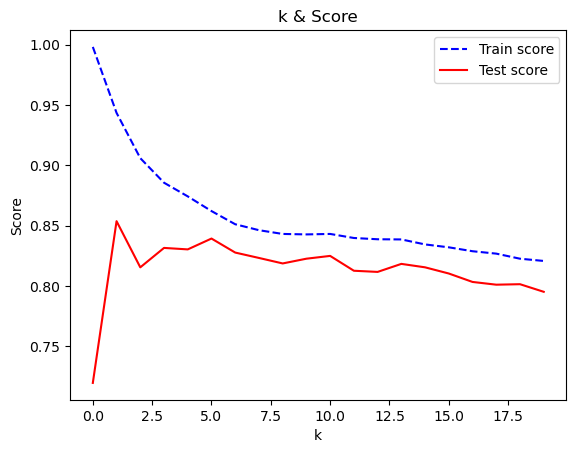

최적의 이웃 개수 k = 2
degree : 2, weight : uniform, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 0.95 --- Test Score : 0.78



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


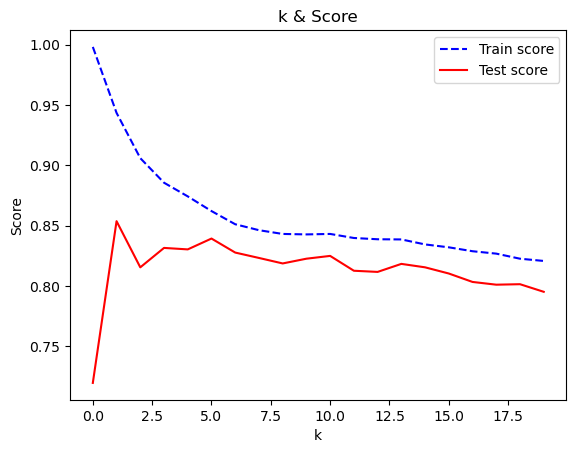

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


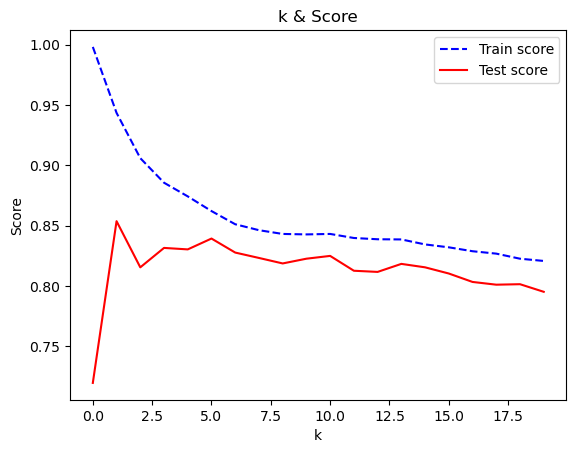

최적의 이웃 개수 k = 2
degree : 2, weight : uniform, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 0.93 --- Test Score : 0.81



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


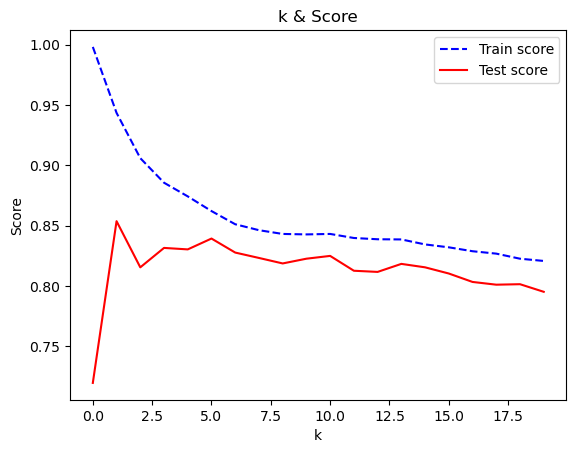

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


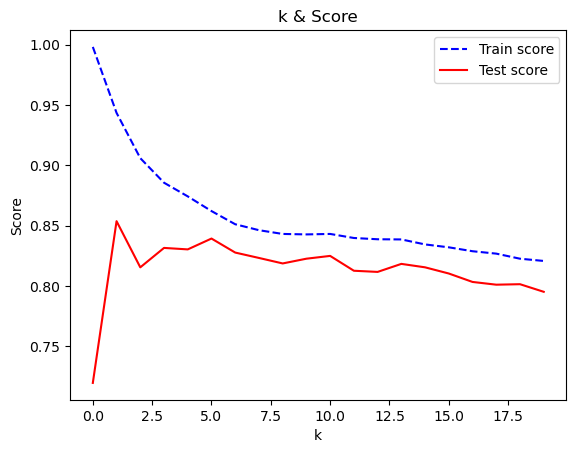

최적의 이웃 개수 k = 2
degree : 2, weight : uniform, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.85



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


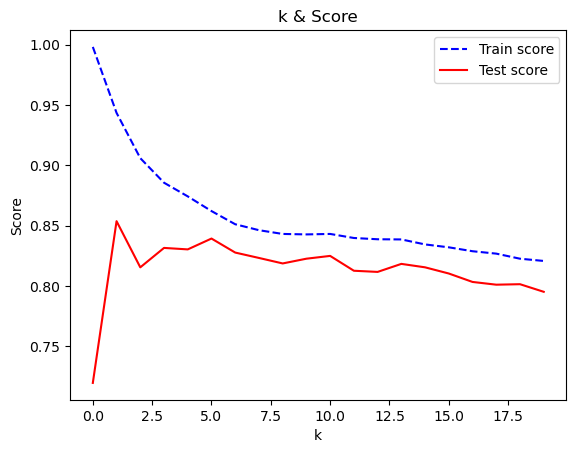

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


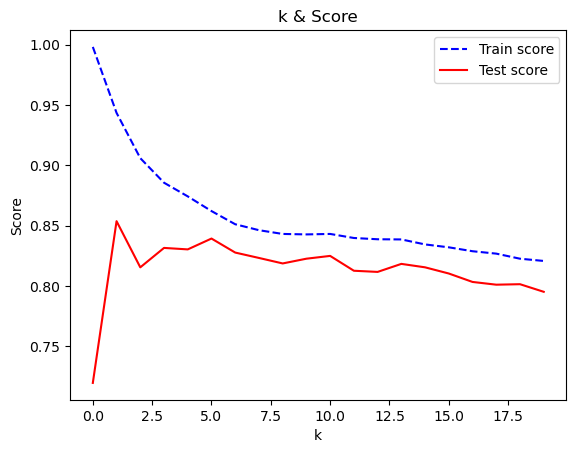

최적의 이웃 개수 k = 2
degree : 2, weight : uniform, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 0.95 --- Test Score : 0.78



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


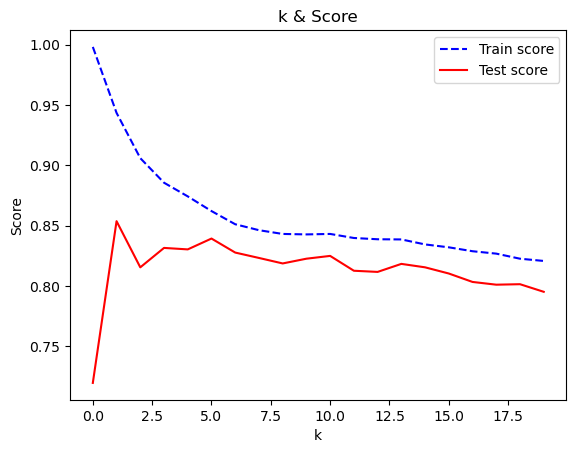

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


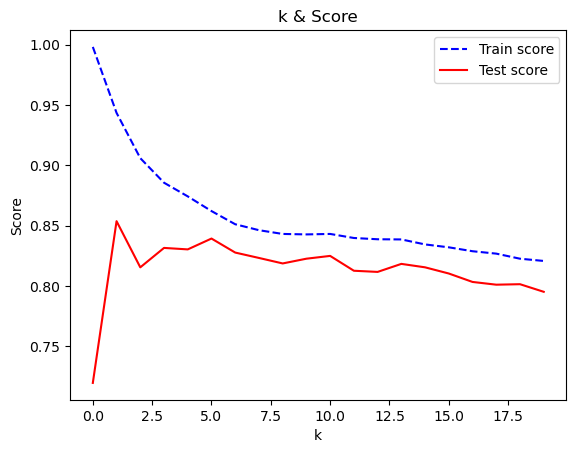

최적의 이웃 개수 k = 2
degree : 2, weight : uniform, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.85



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


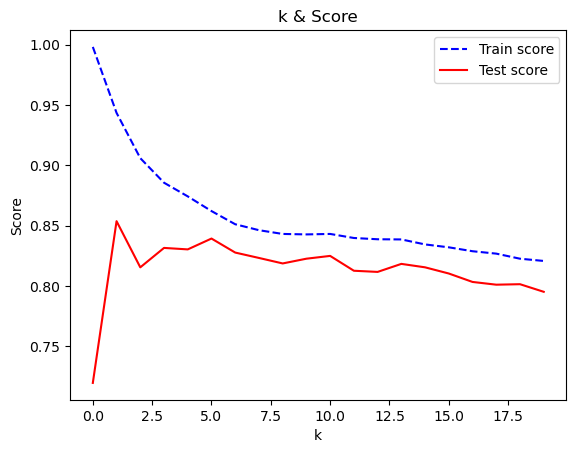

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


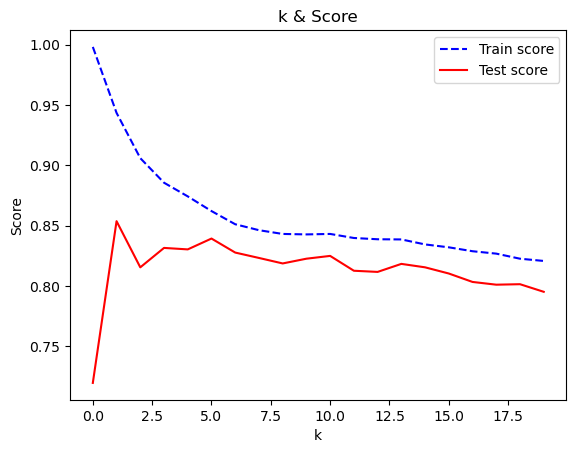

최적의 이웃 개수 k = 2
degree : 2, weight : uniform, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 0.95 --- Test Score : 0.78



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


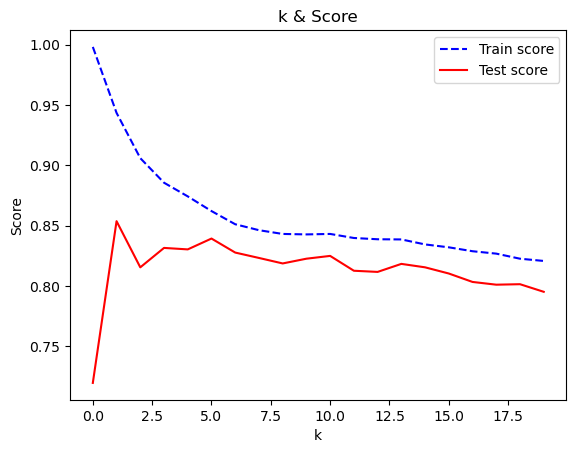

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


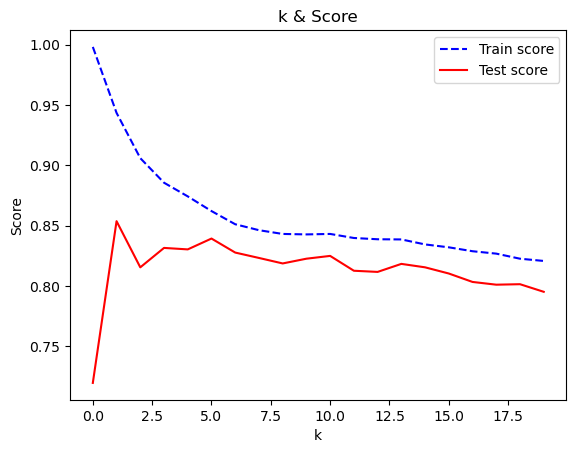

최적의 이웃 개수 k = 2
degree : 2, weight : uniform, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.85



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


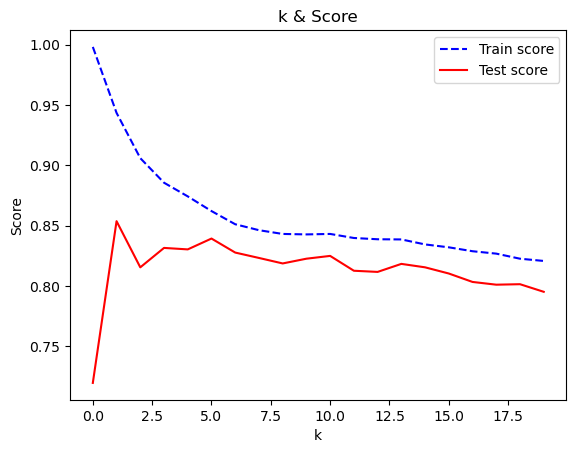

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


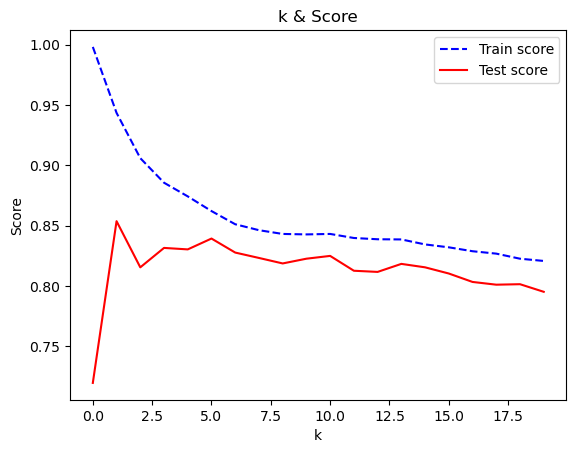

최적의 이웃 개수 k = 2
degree : 2, weight : distance, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.78



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


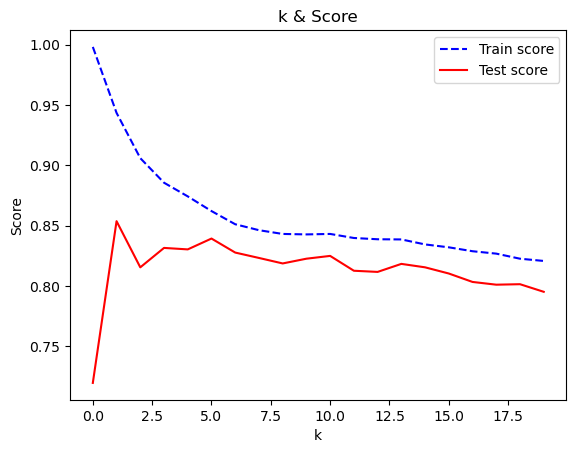

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


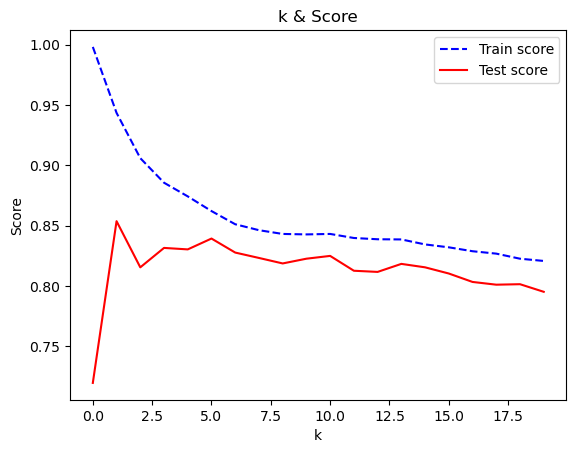

최적의 이웃 개수 k = 2
degree : 2, weight : distance, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.75



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


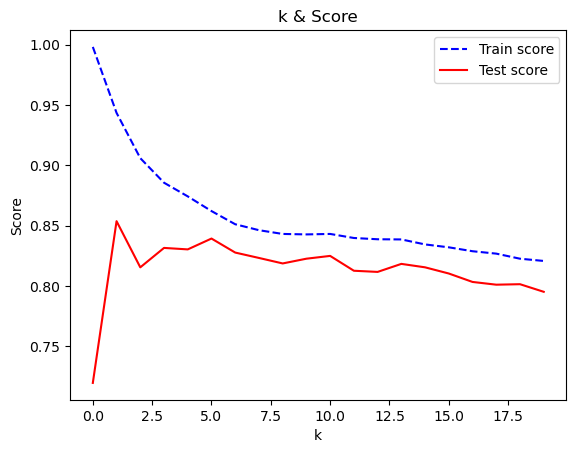

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


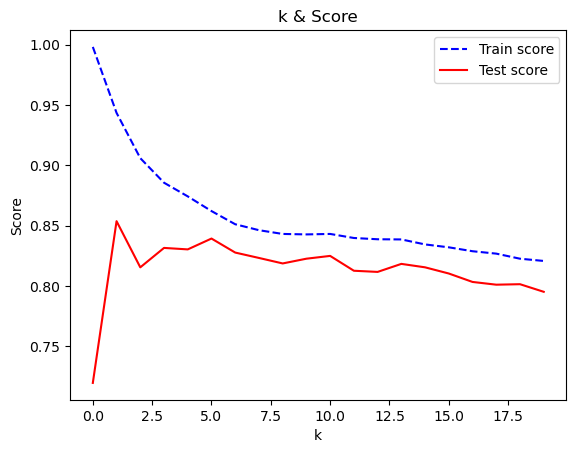

최적의 이웃 개수 k = 2
degree : 2, weight : distance, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


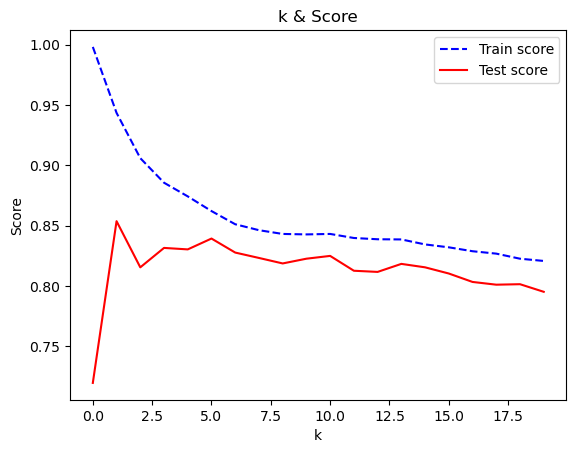

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


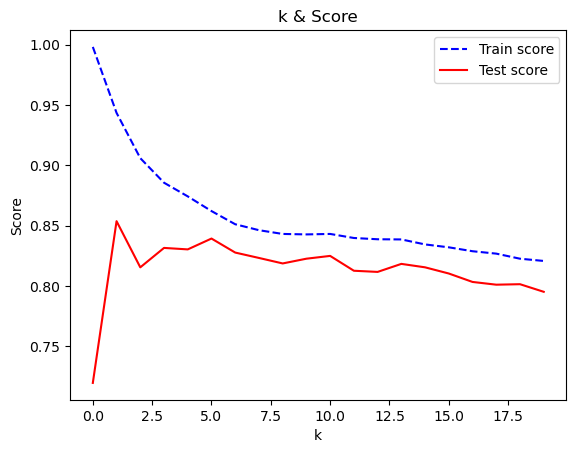

최적의 이웃 개수 k = 2
degree : 2, weight : distance, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.78



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


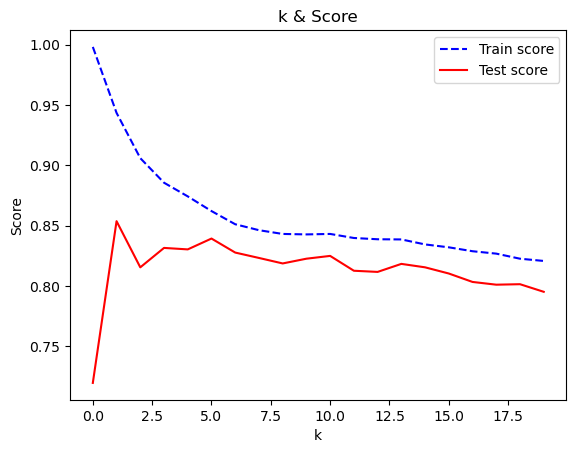

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


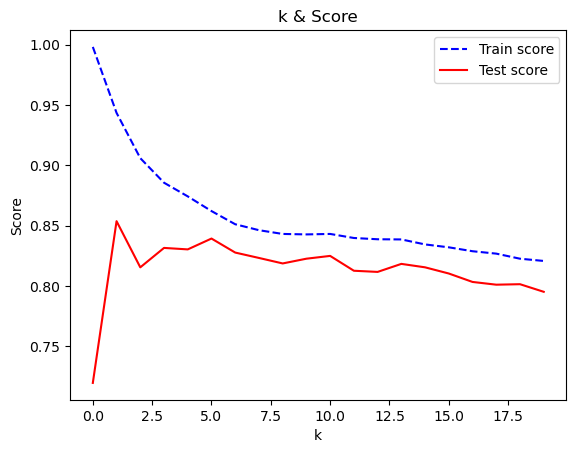

최적의 이웃 개수 k = 2
degree : 2, weight : distance, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


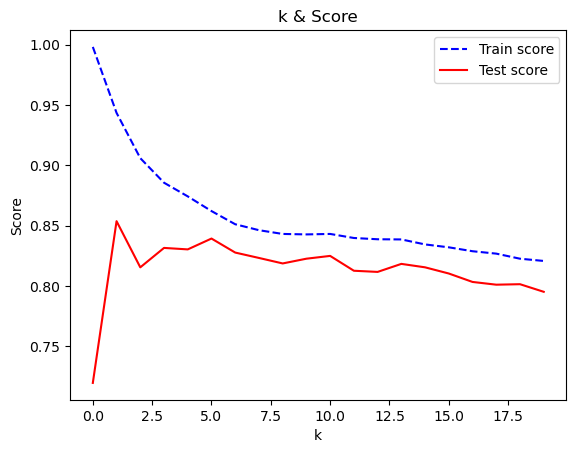

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


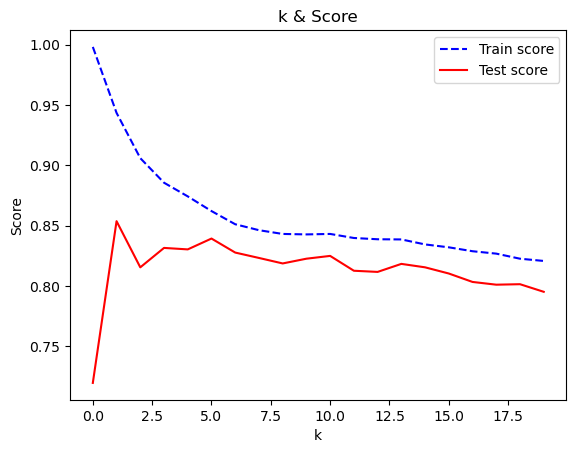

최적의 이웃 개수 k = 2
degree : 2, weight : distance, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.78



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


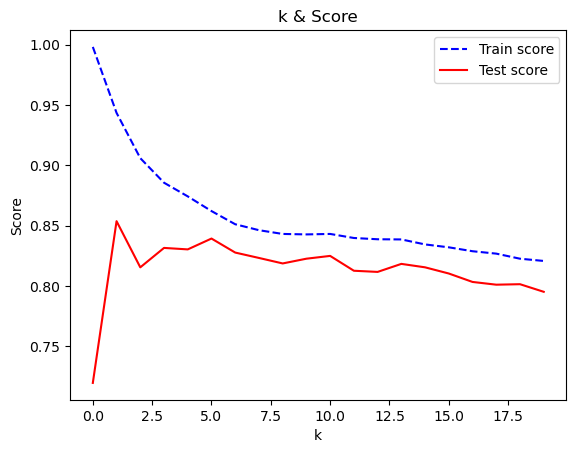

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


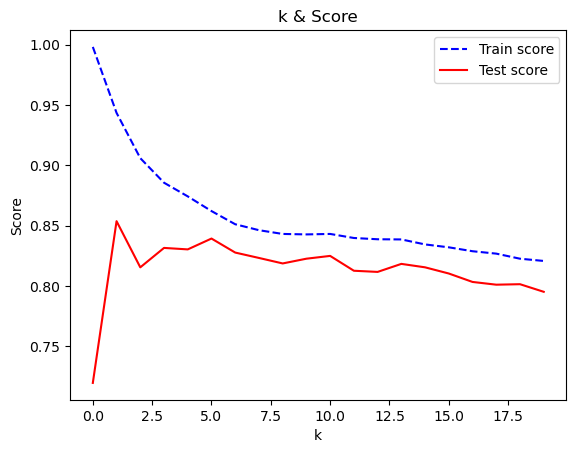

최적의 이웃 개수 k = 2
degree : 2, weight : distance, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


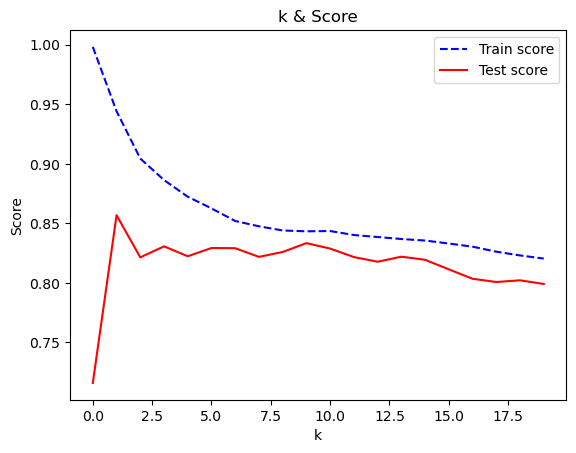

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


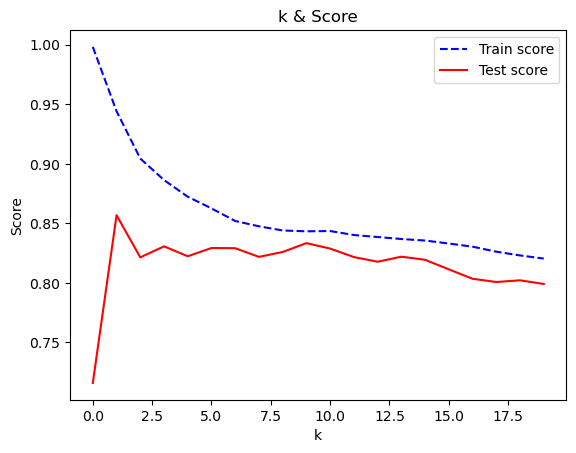

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 0.95 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


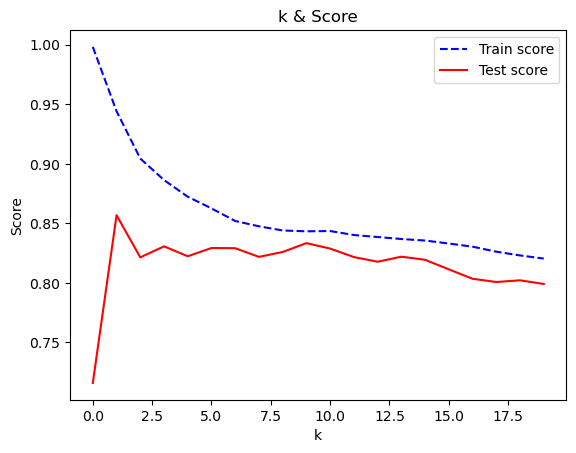

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


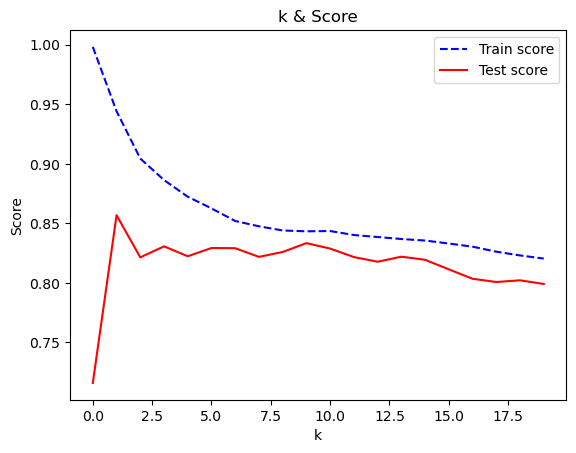

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


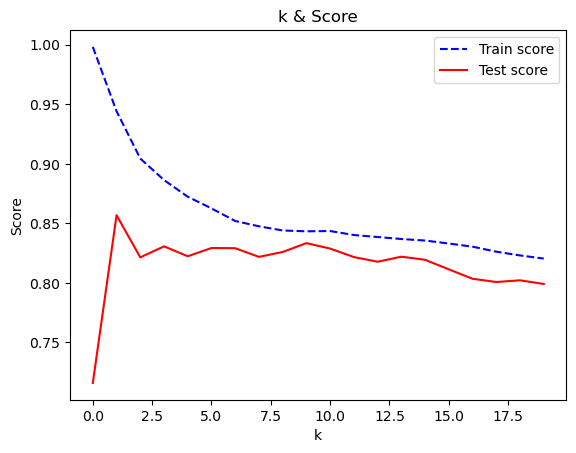

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


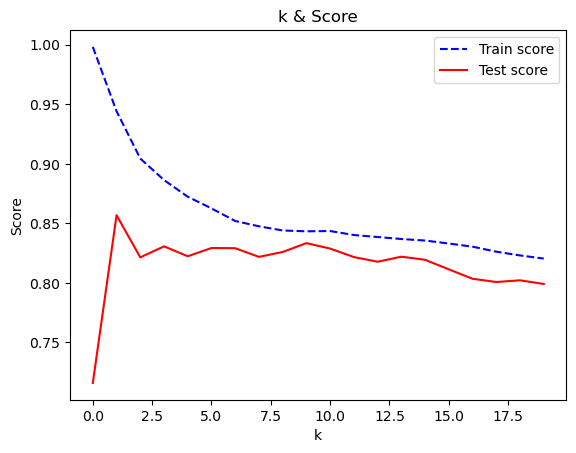

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


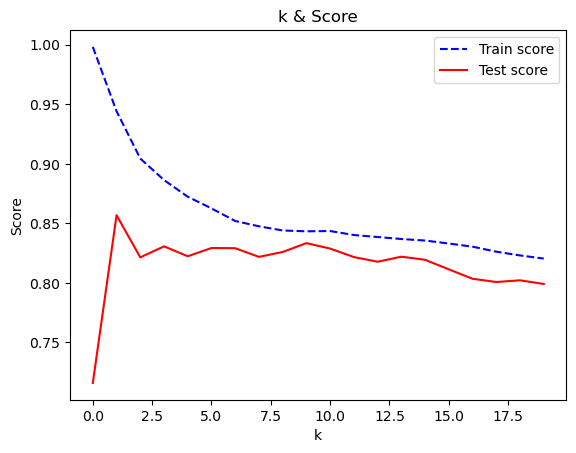

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


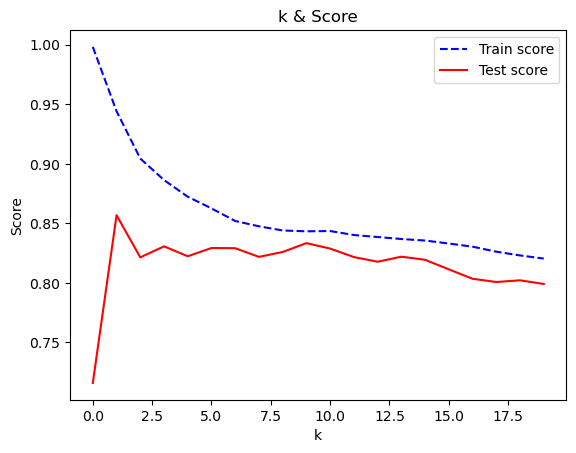

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 0.95 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


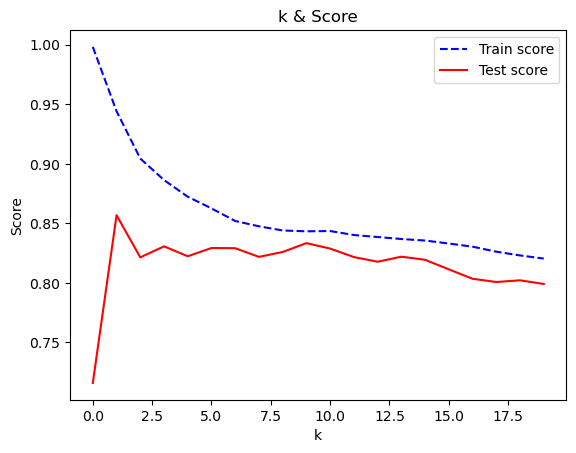

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


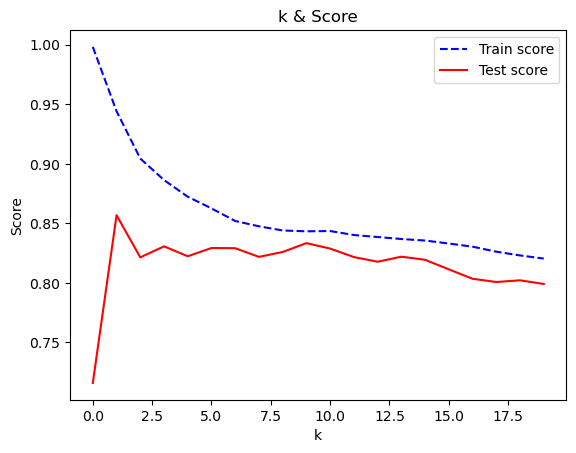

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


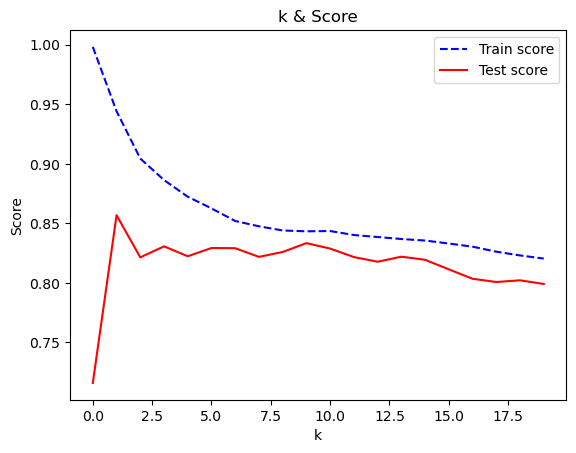

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


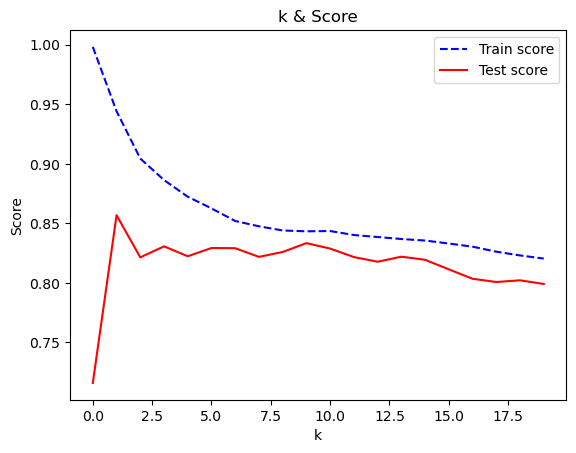

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 0.95 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


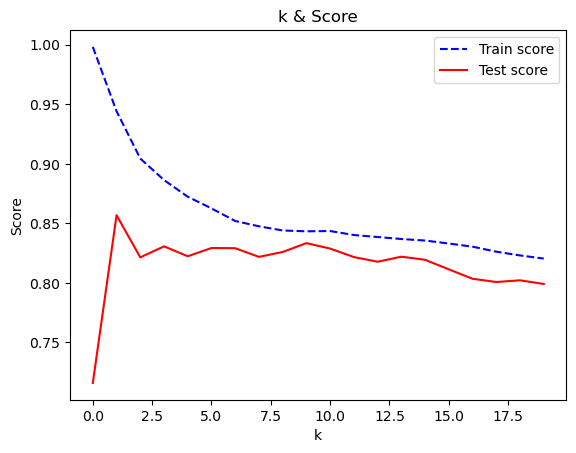

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


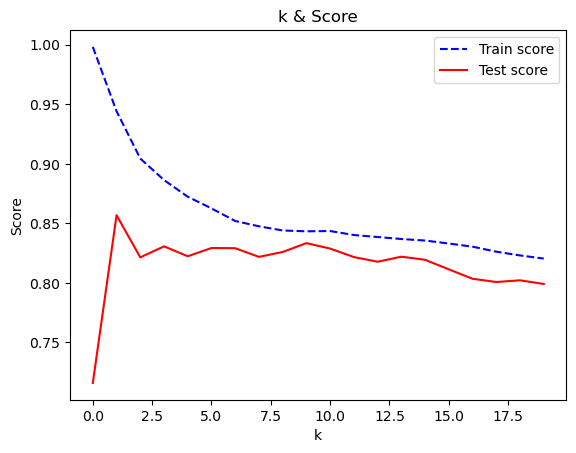

최적의 이웃 개수 k = 2
degree : 3, weight : uniform, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 0.94 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


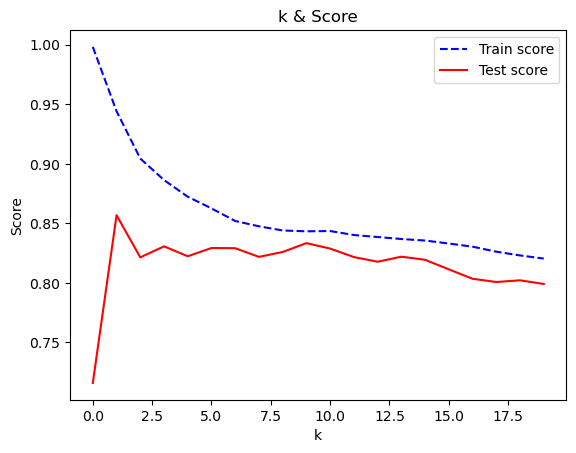

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


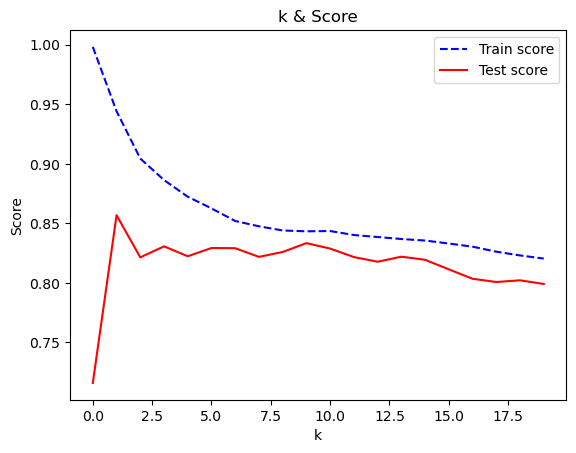

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : cityblock일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


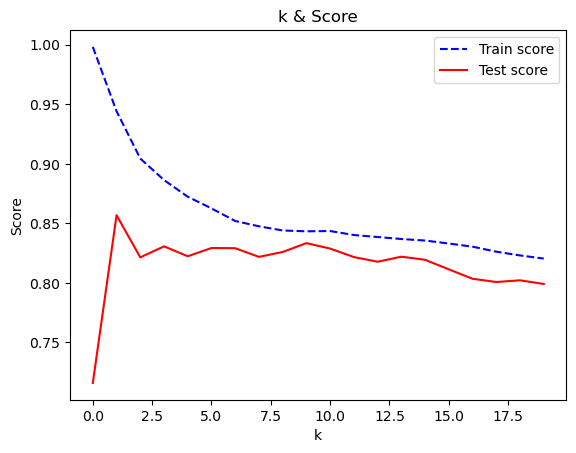

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


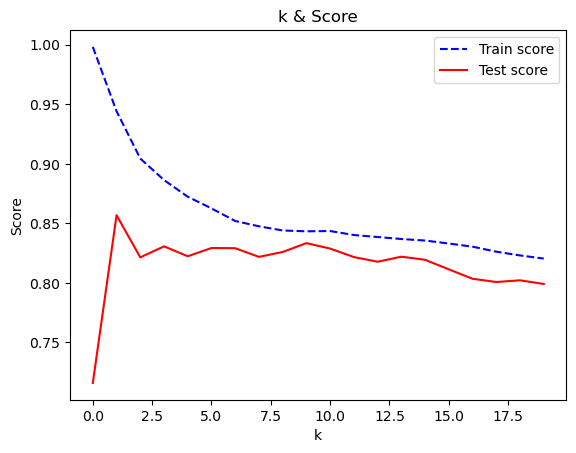

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : cosine일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.75



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


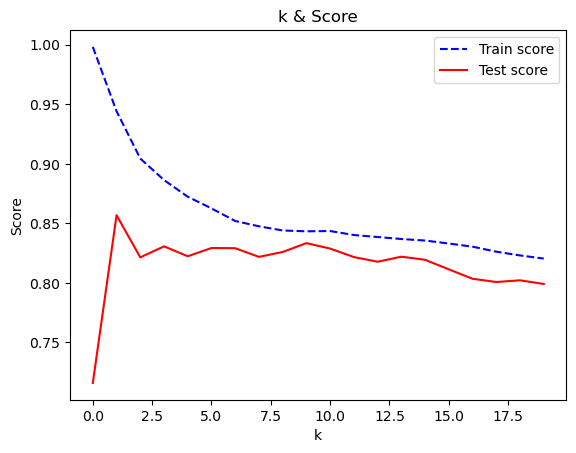

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


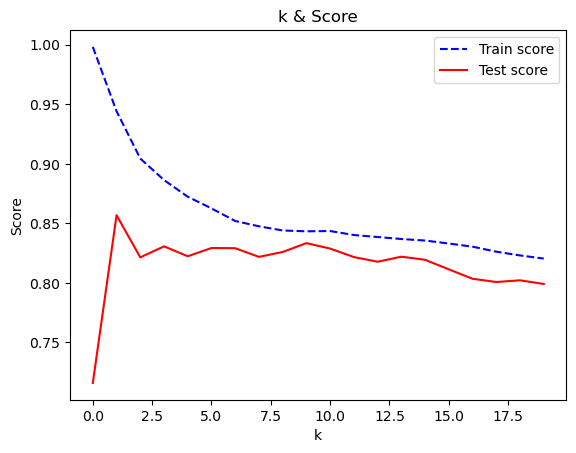

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : euclidean일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


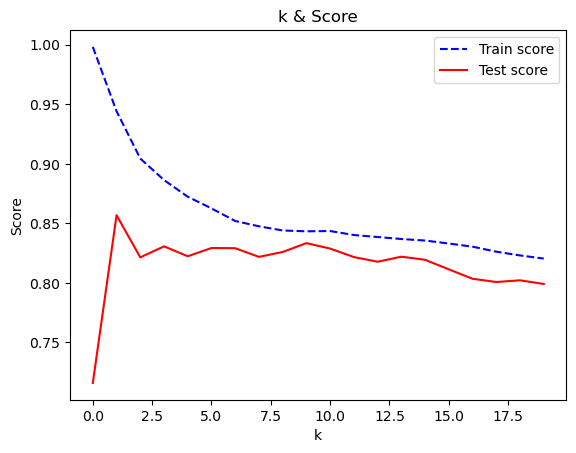

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


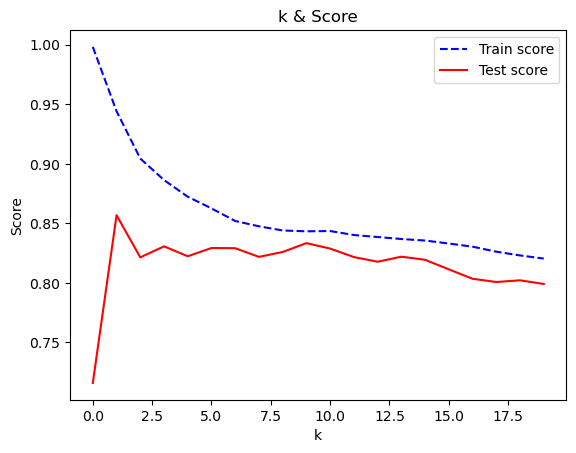

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : l1일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


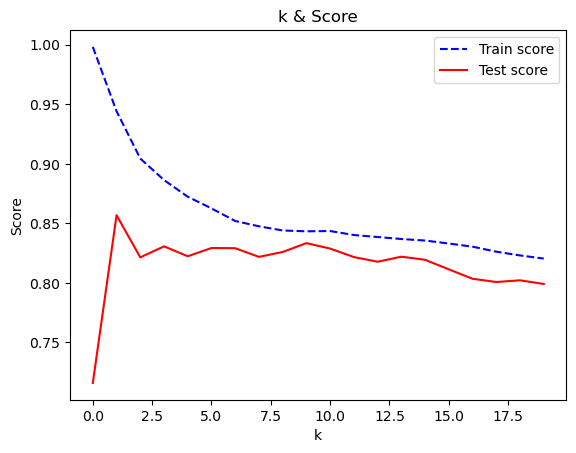

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


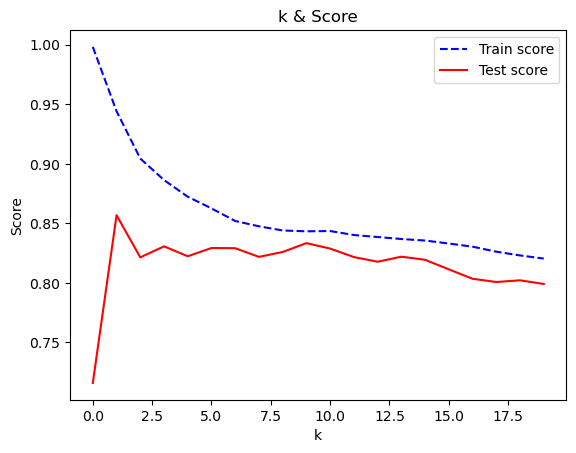

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : l2일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


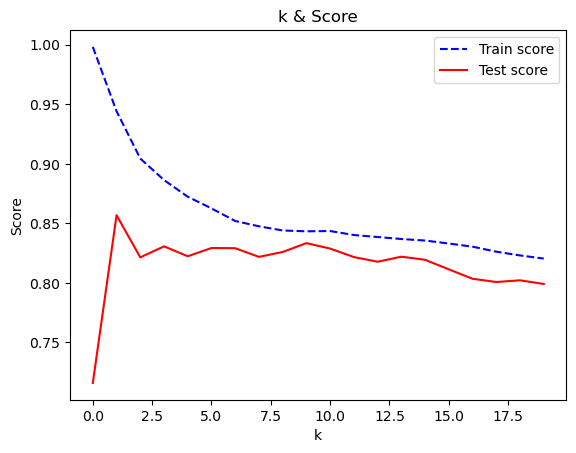

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


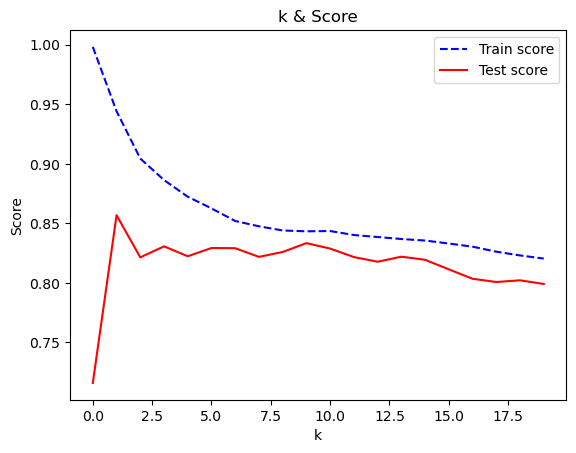

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : manhattan일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


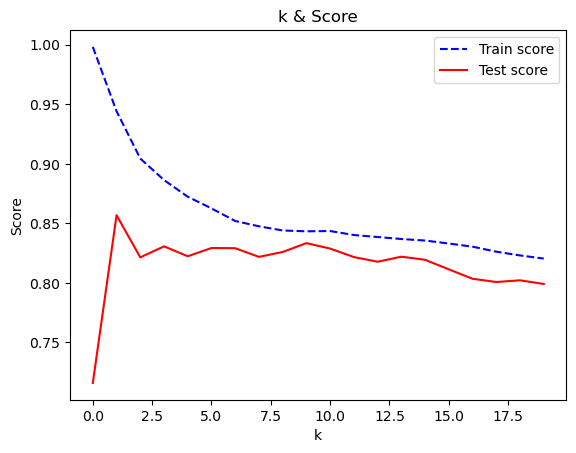

최적의 이웃 개수 k = 2


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


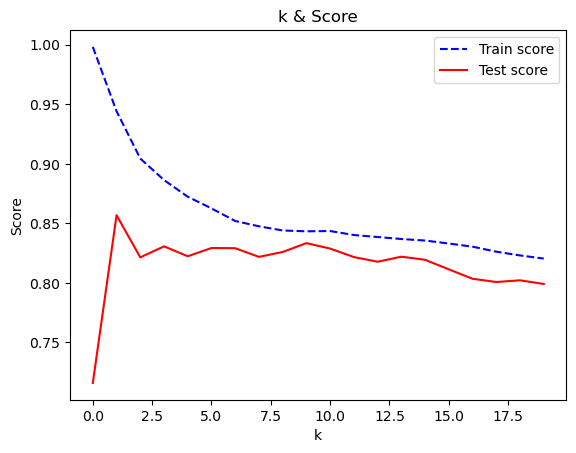

최적의 이웃 개수 k = 2
degree : 3, weight : distance, metric : nan_euclidean일 때 ===>

MinMaxScaler() => Train Score : 1.0 --- Test Score : 0.79



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


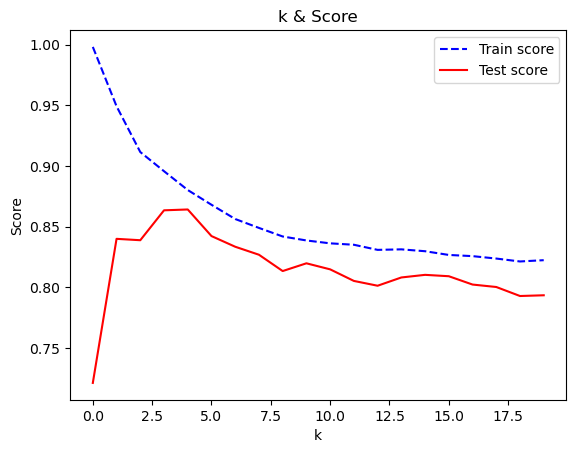

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


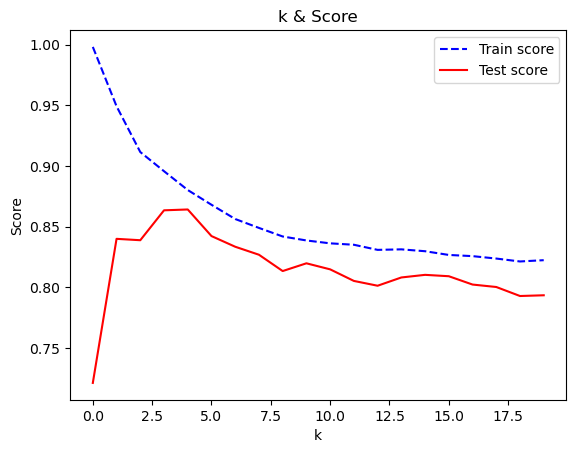

최적의 이웃 개수 k = 5
degree : 2, weight : uniform, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


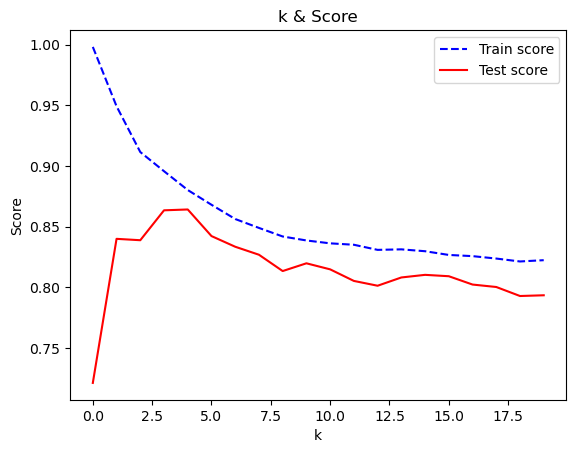

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


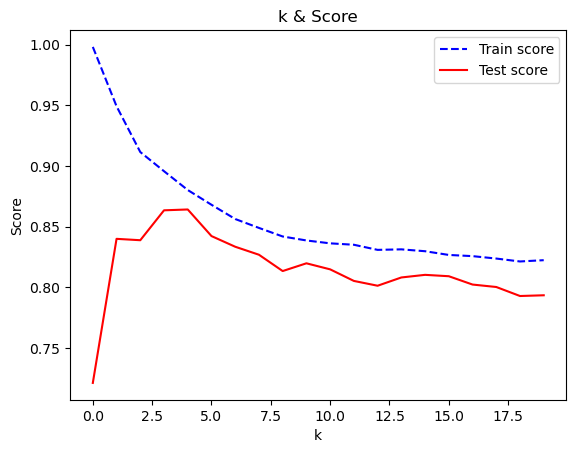

최적의 이웃 개수 k = 5
degree : 2, weight : uniform, metric : cosine일 때 ===>

RobustScaler() => Train Score : 0.87 --- Test Score : 0.82



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


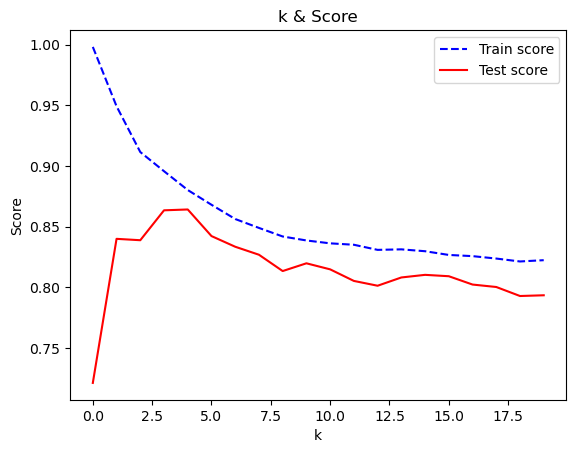

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


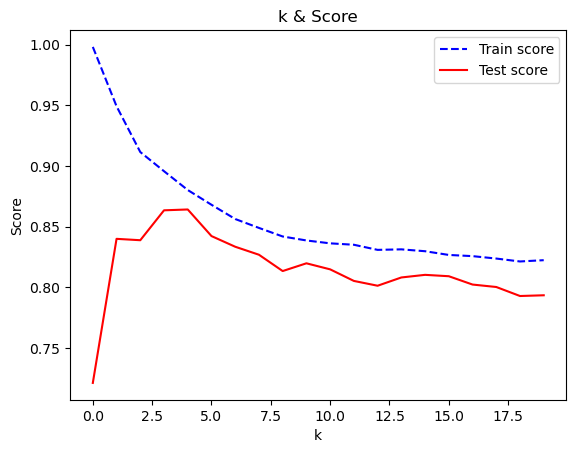

최적의 이웃 개수 k = 5
degree : 2, weight : uniform, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 0.88 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


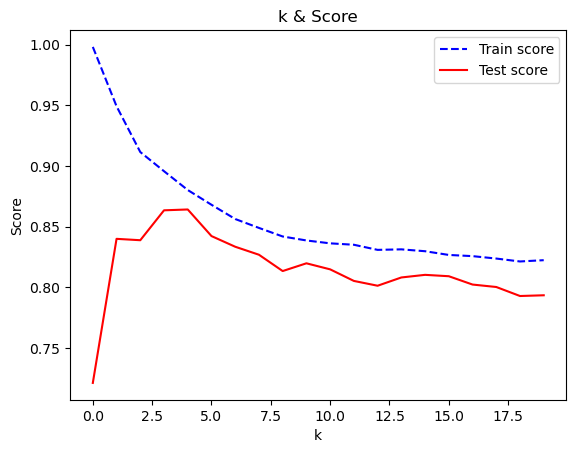

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


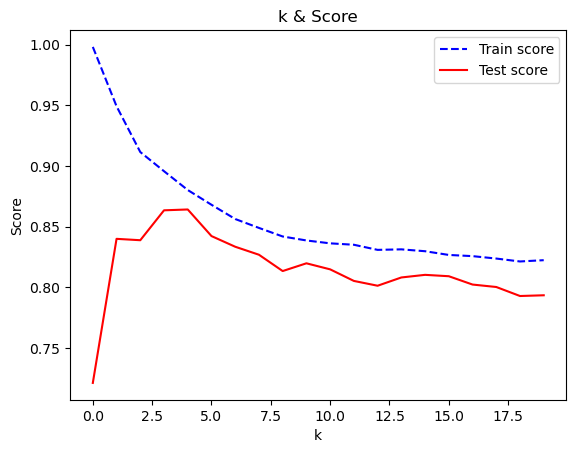

최적의 이웃 개수 k = 5
degree : 2, weight : uniform, metric : l1일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


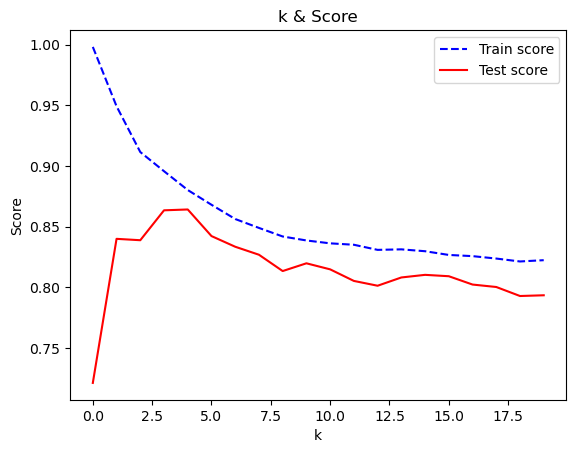

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


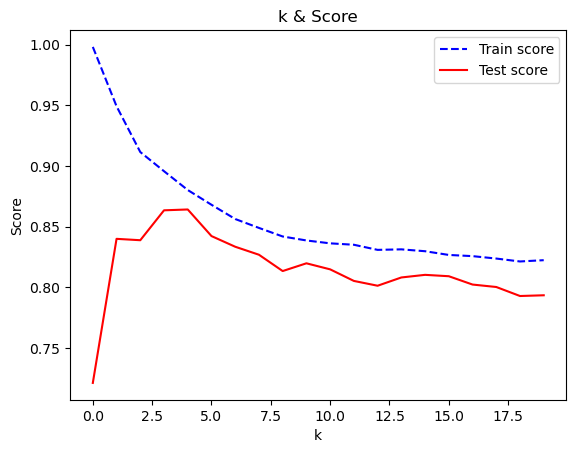

최적의 이웃 개수 k = 5
degree : 2, weight : uniform, metric : l2일 때 ===>

RobustScaler() => Train Score : 0.88 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


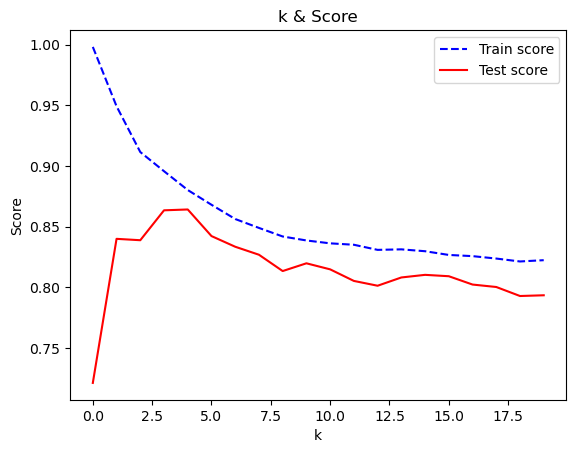

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


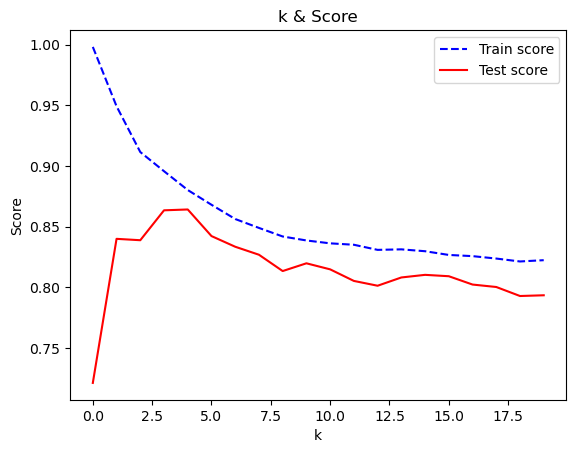

최적의 이웃 개수 k = 5
degree : 2, weight : uniform, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


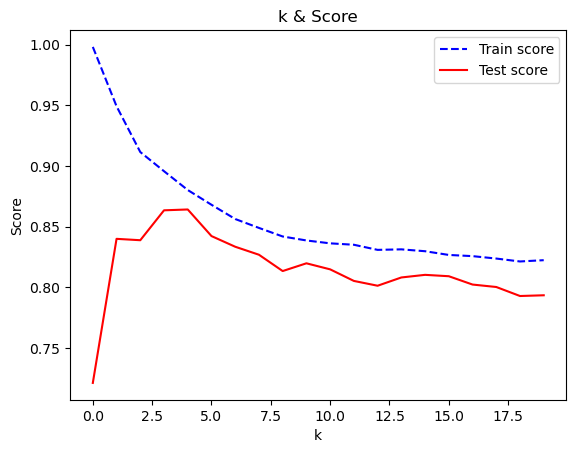

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


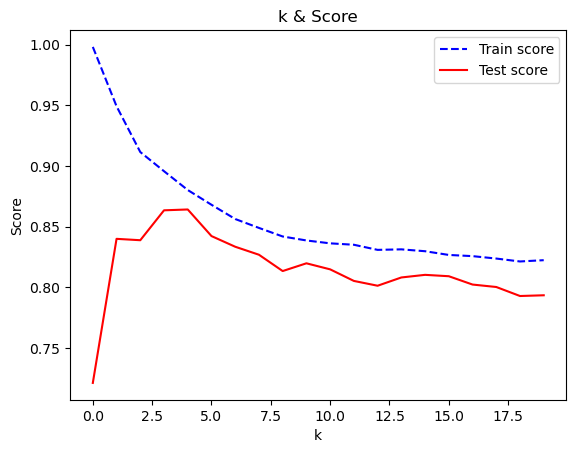

최적의 이웃 개수 k = 5
degree : 2, weight : uniform, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 0.88 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


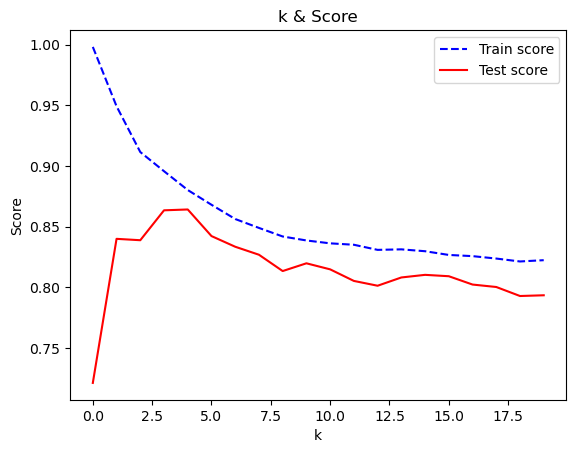

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


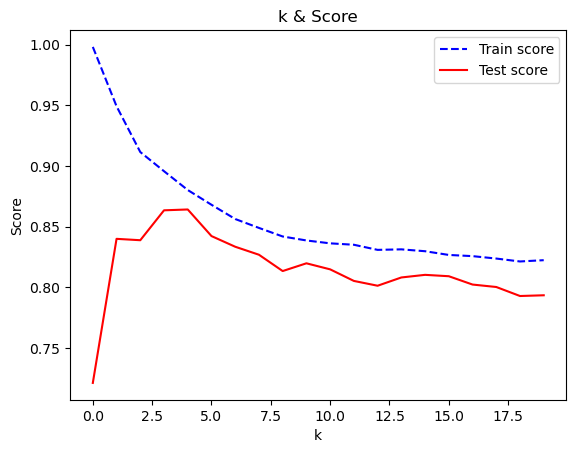

최적의 이웃 개수 k = 5
degree : 2, weight : distance, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


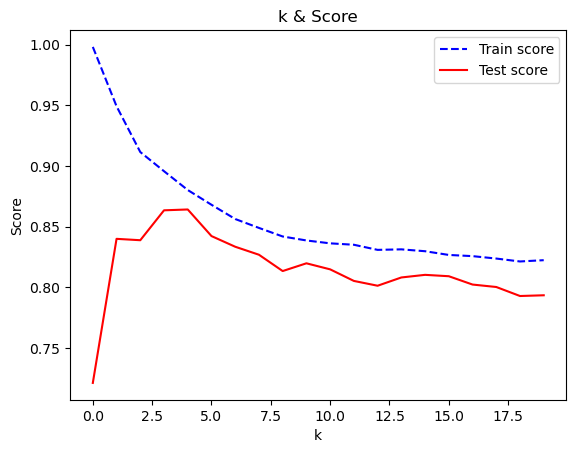

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


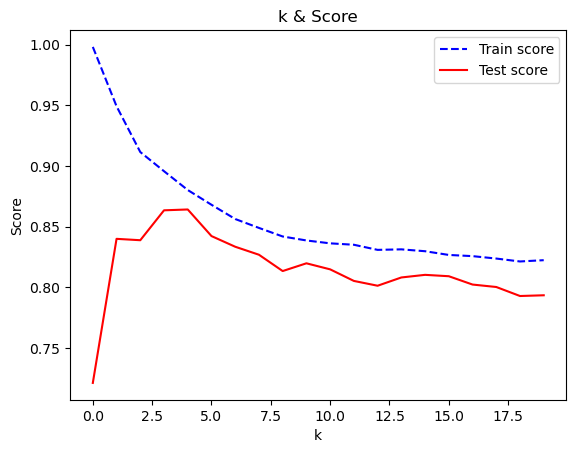

최적의 이웃 개수 k = 5
degree : 2, weight : distance, metric : cosine일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


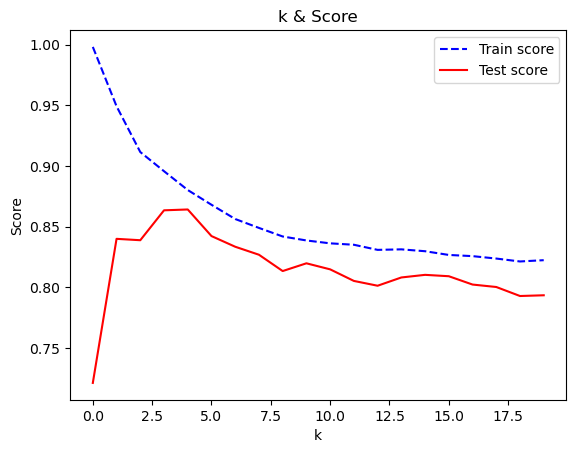

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


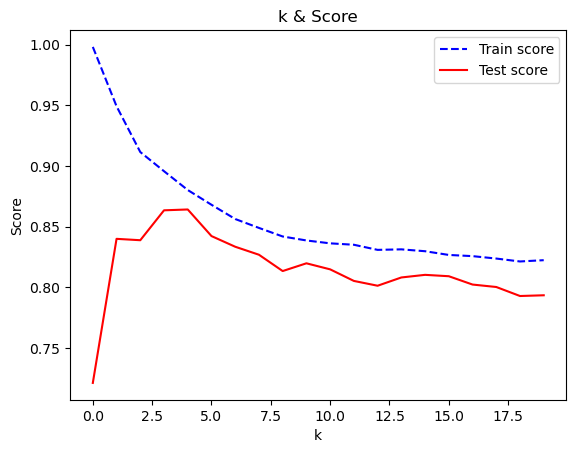

최적의 이웃 개수 k = 5
degree : 2, weight : distance, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


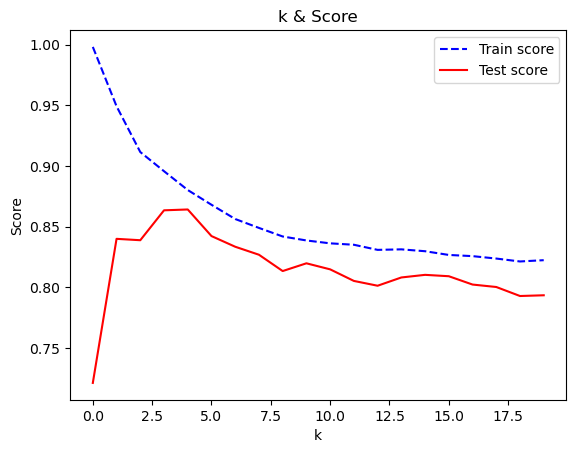

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


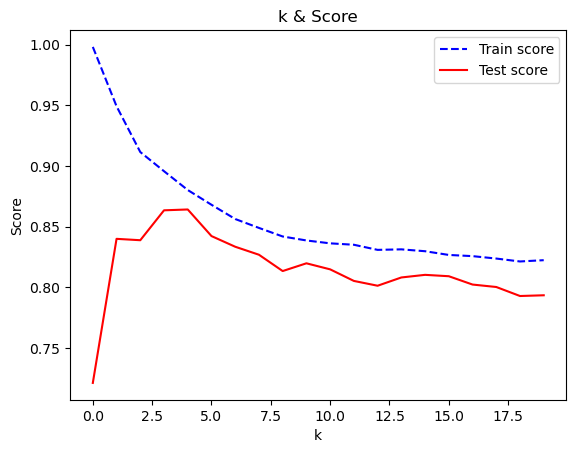

최적의 이웃 개수 k = 5
degree : 2, weight : distance, metric : l1일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


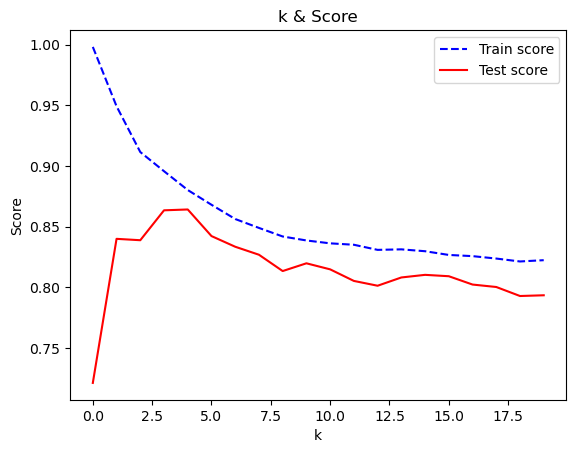

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


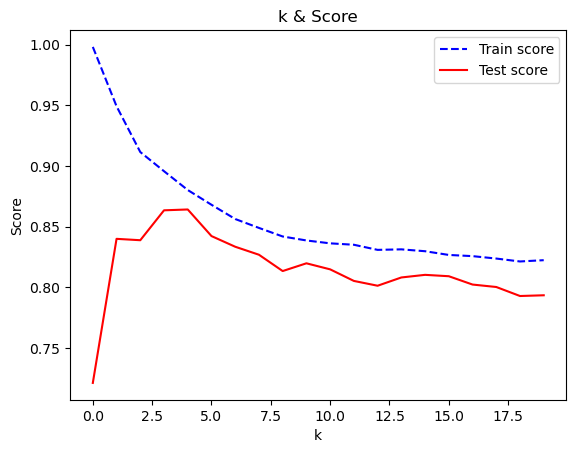

최적의 이웃 개수 k = 5
degree : 2, weight : distance, metric : l2일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


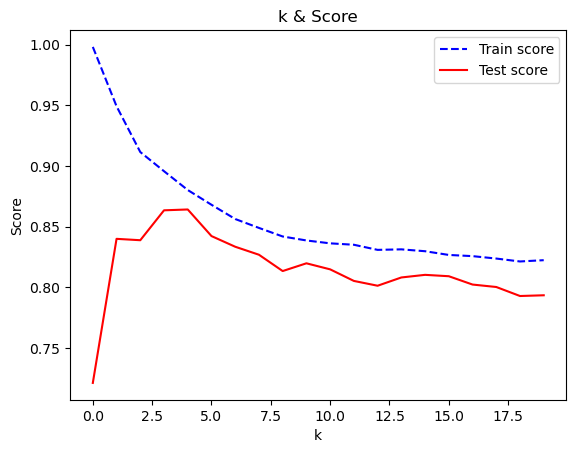

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


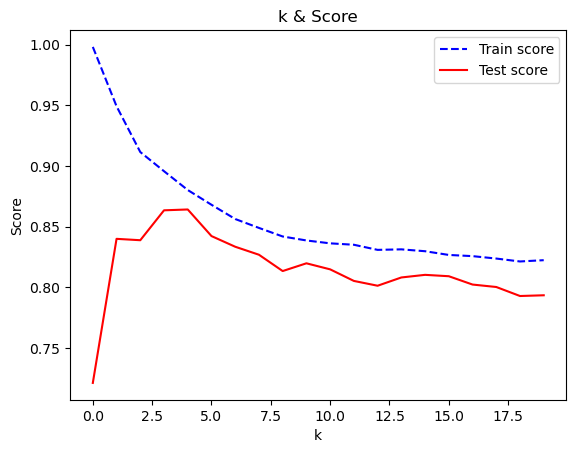

최적의 이웃 개수 k = 5
degree : 2, weight : distance, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


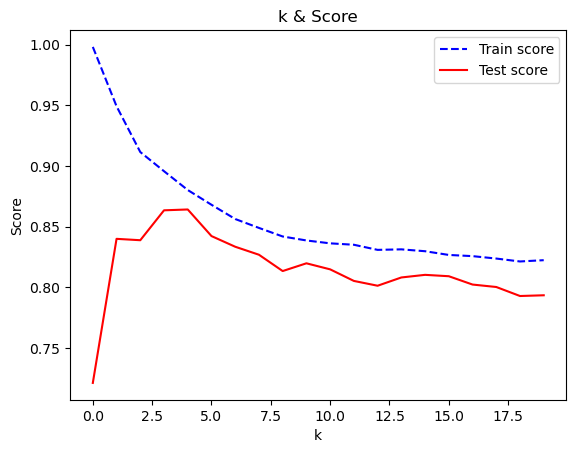

최적의 이웃 개수 k = 5


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


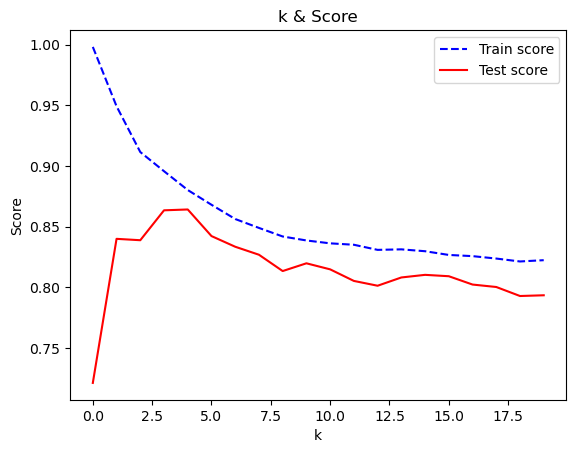

최적의 이웃 개수 k = 5
degree : 2, weight : distance, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.9



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


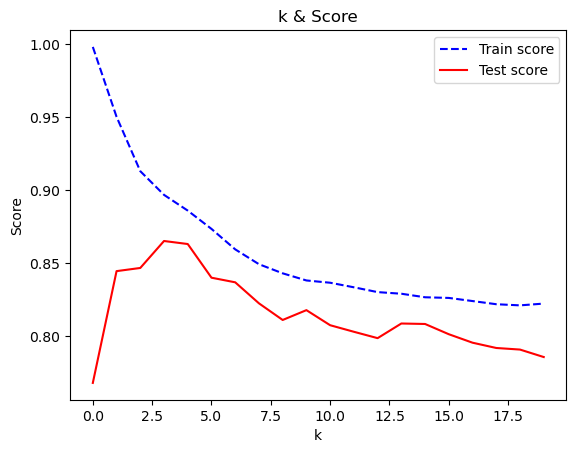

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


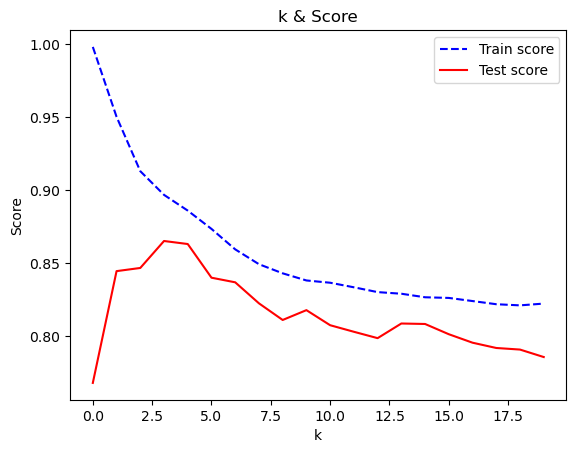

최적의 이웃 개수 k = 4
degree : 3, weight : uniform, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


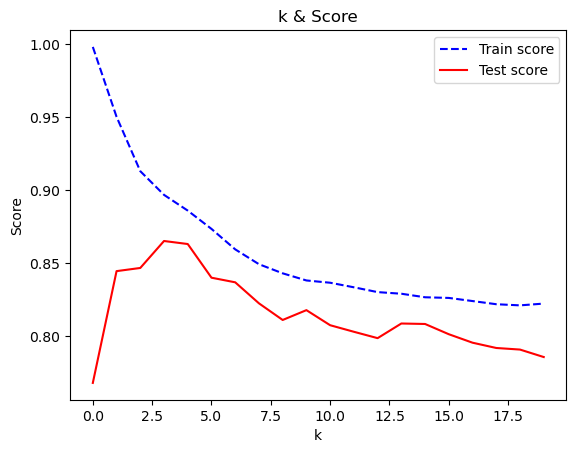

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


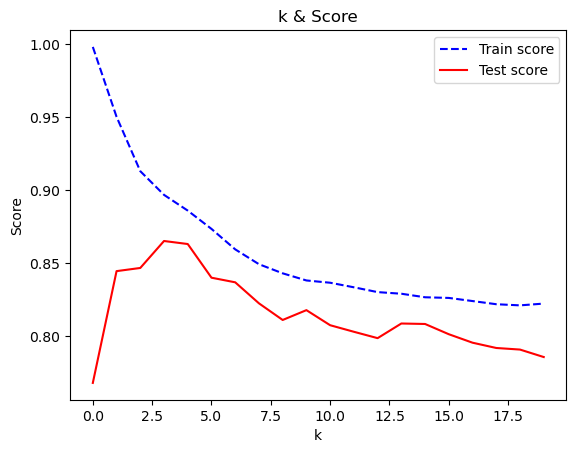

최적의 이웃 개수 k = 4
degree : 3, weight : uniform, metric : cosine일 때 ===>

RobustScaler() => Train Score : 0.88 --- Test Score : 0.8



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


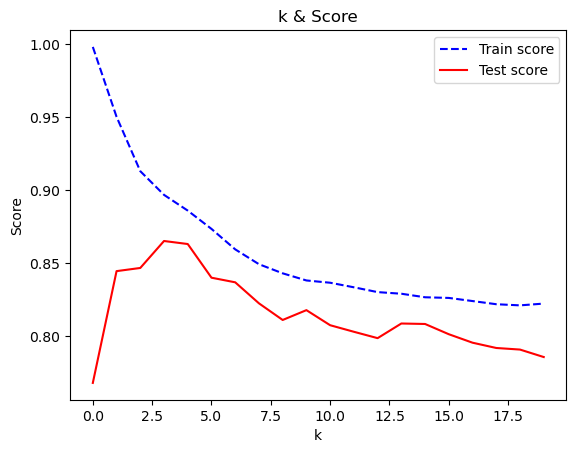

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


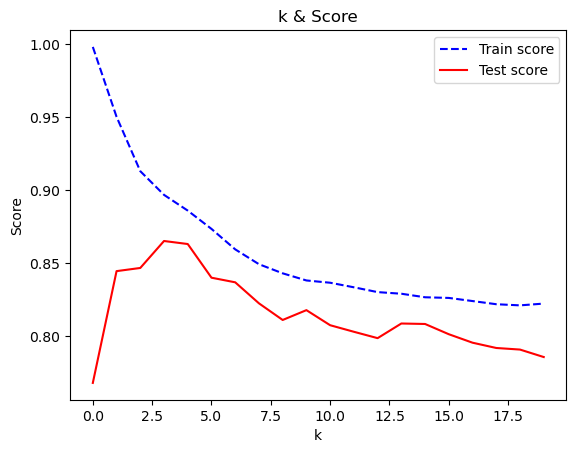

최적의 이웃 개수 k = 4
degree : 3, weight : uniform, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


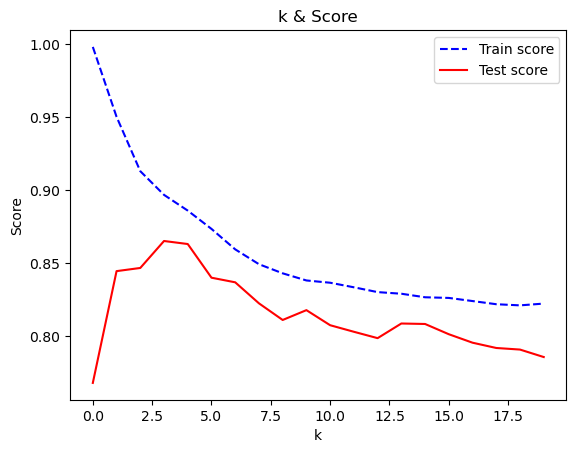

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


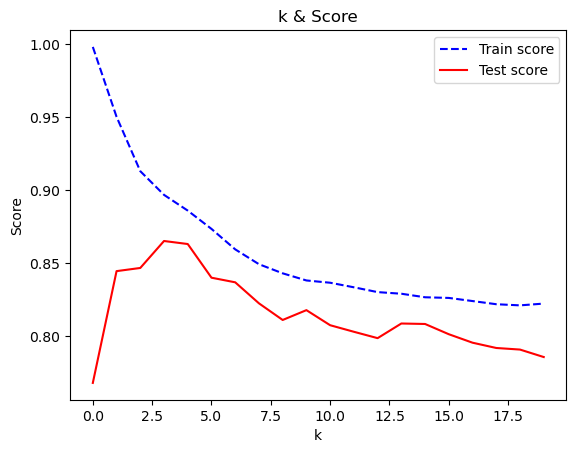

최적의 이웃 개수 k = 4
degree : 3, weight : uniform, metric : l1일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


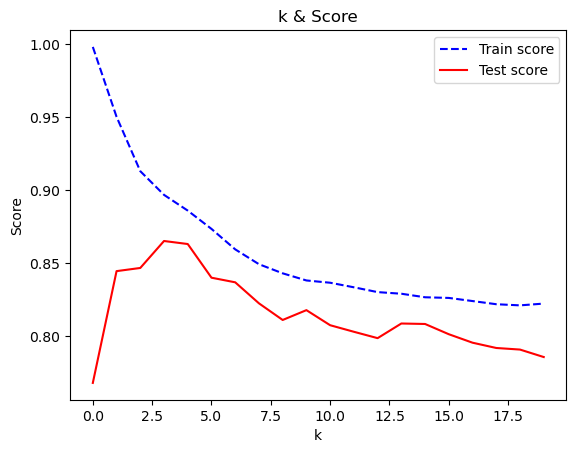

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


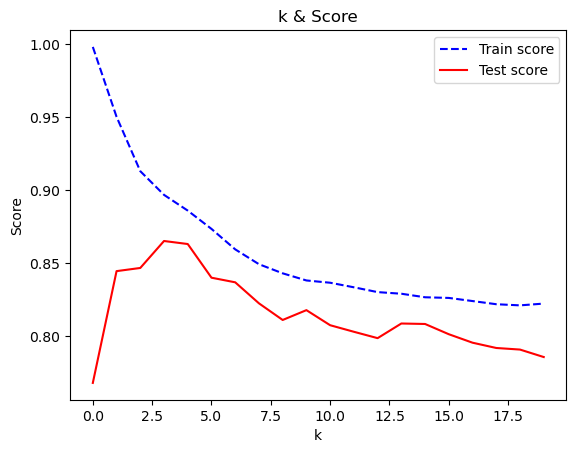

최적의 이웃 개수 k = 4
degree : 3, weight : uniform, metric : l2일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


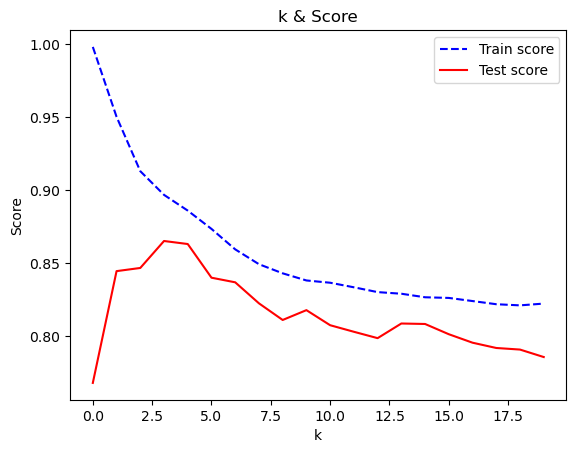

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


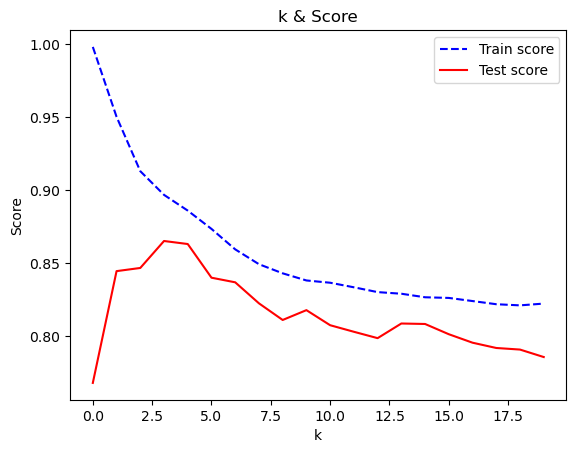

최적의 이웃 개수 k = 4
degree : 3, weight : uniform, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 0.89 --- Test Score : 0.86



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


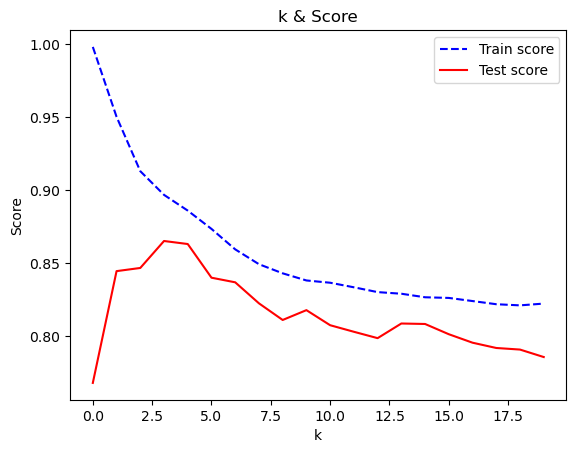

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


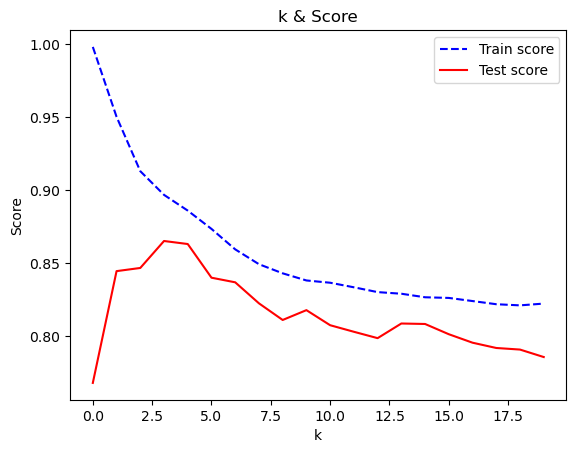

최적의 이웃 개수 k = 4
degree : 3, weight : uniform, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 0.9 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


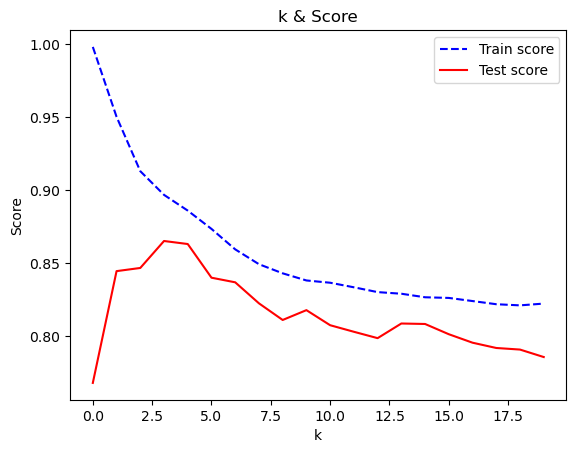

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


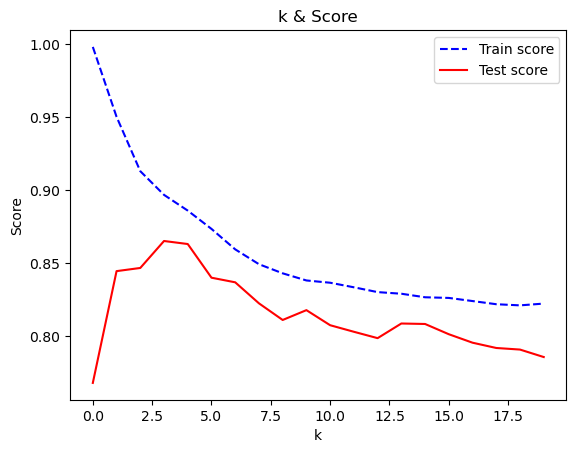

최적의 이웃 개수 k = 4
degree : 3, weight : distance, metric : cityblock일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


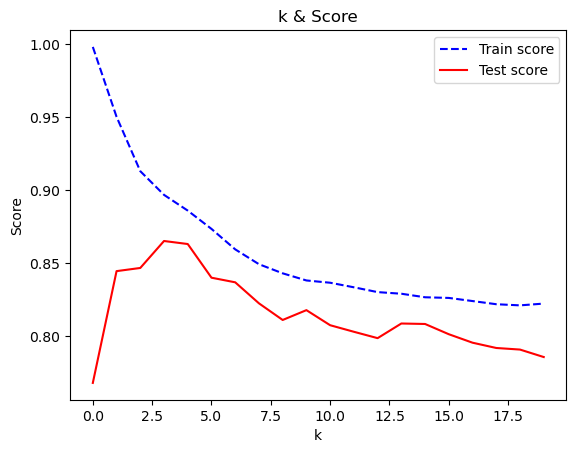

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


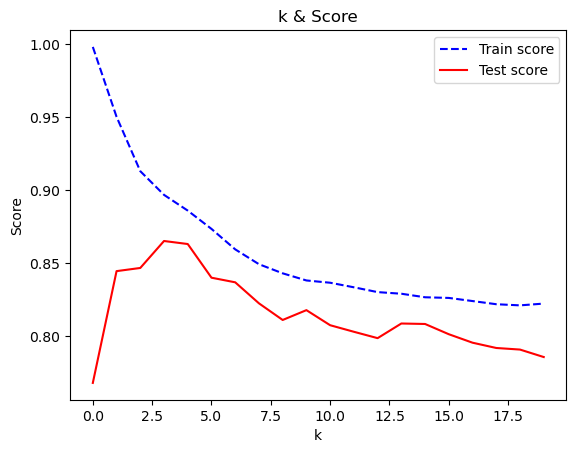

최적의 이웃 개수 k = 4
degree : 3, weight : distance, metric : cosine일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.85



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


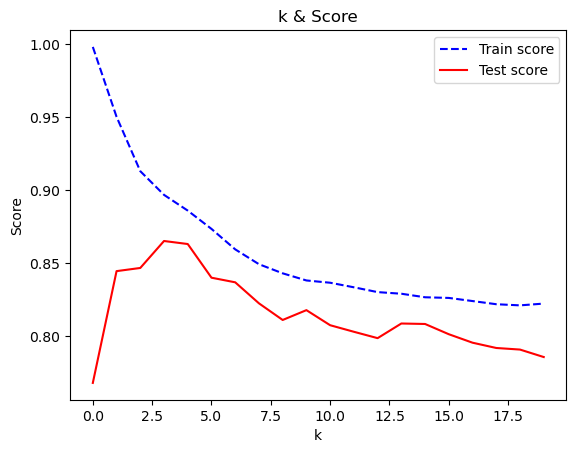

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


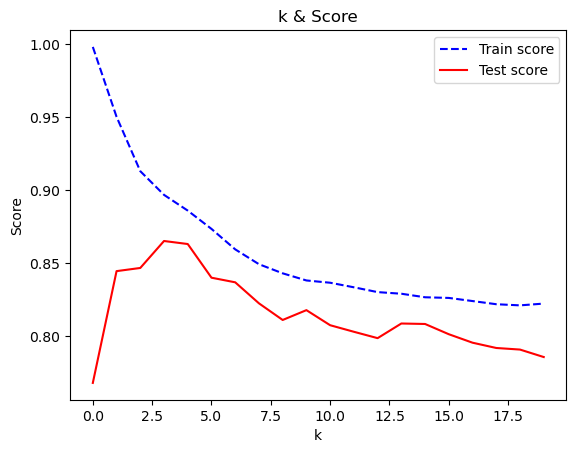

최적의 이웃 개수 k = 4
degree : 3, weight : distance, metric : euclidean일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


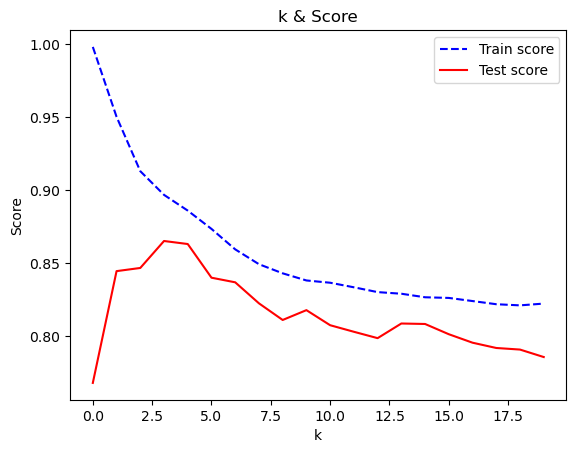

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


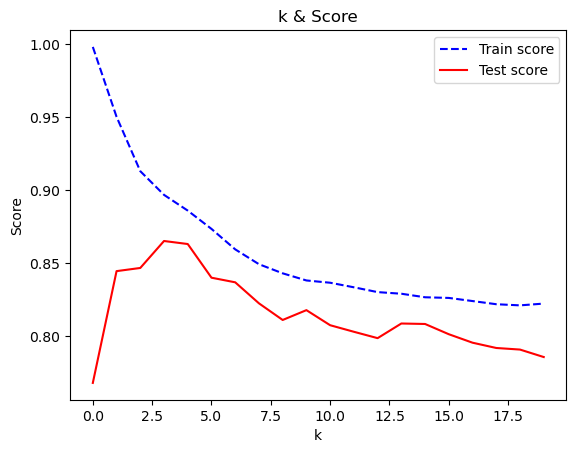

최적의 이웃 개수 k = 4
degree : 3, weight : distance, metric : l1일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


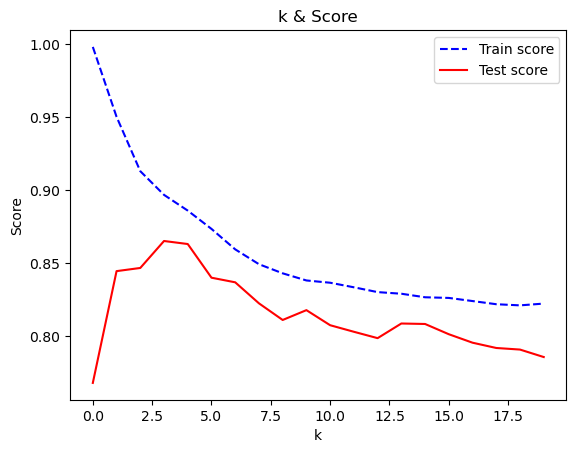

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


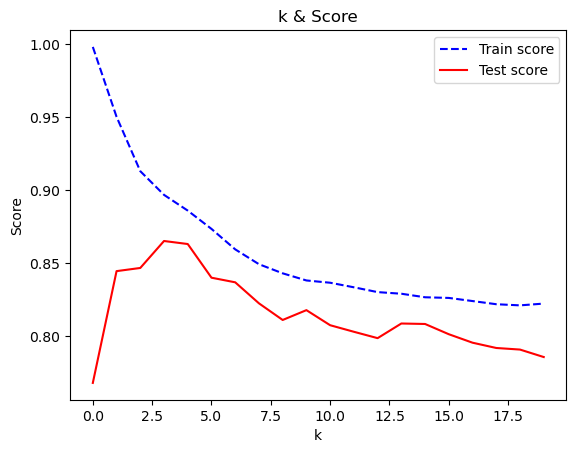

최적의 이웃 개수 k = 4
degree : 3, weight : distance, metric : l2일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.89



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


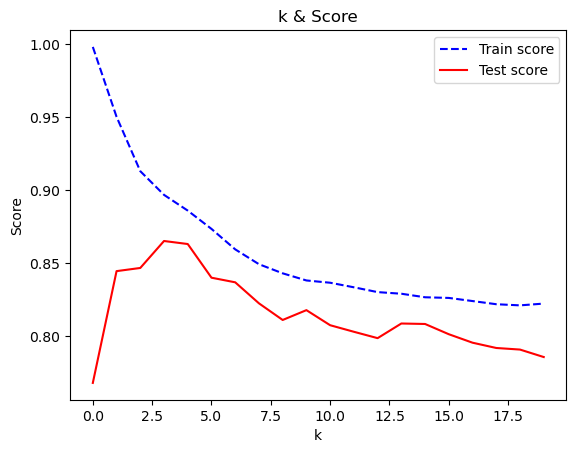

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


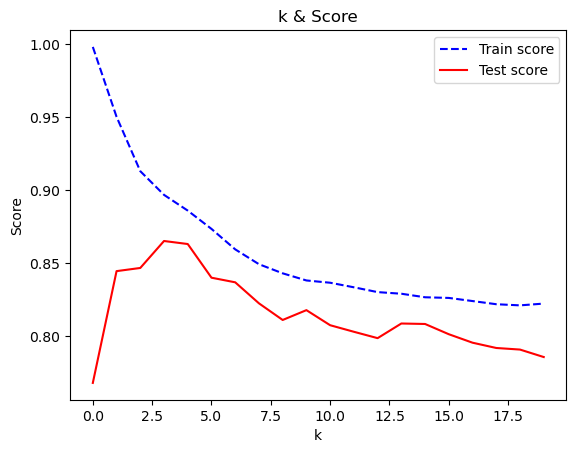

최적의 이웃 개수 k = 4
degree : 3, weight : distance, metric : manhattan일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.87



c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


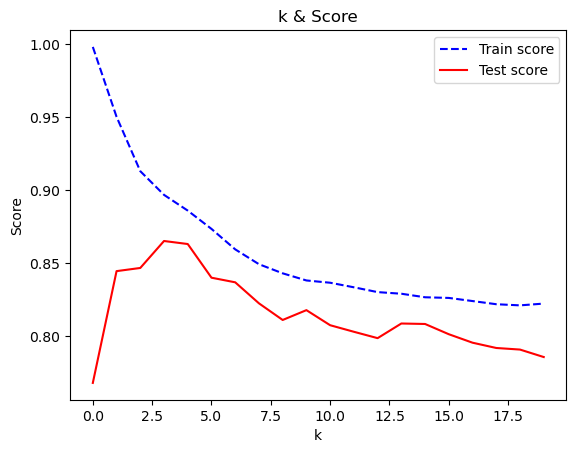

최적의 이웃 개수 k = 4


c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


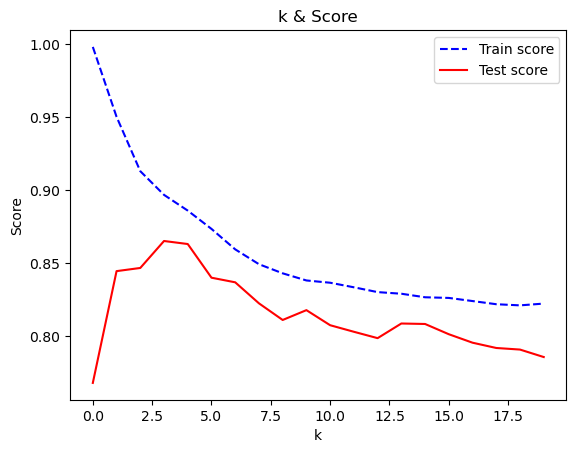

최적의 이웃 개수 k = 4
degree : 3, weight : distance, metric : nan_euclidean일 때 ===>

RobustScaler() => Train Score : 1.0 --- Test Score : 0.89



In [94]:
# KNeighborsRegressor 학습
def main(start_degree, end_degree):
    degree_list = list(range(start_degree, end_degree + 1))
    weight_list = ['uniform', 'distance']
    metric_list = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']
    for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
        for degree in degree_list:
            for weight in weight_list:
                for metric in metric_list:
                    train_score = score_return(['displacement', 'horsepower', 'weight'], 'mpg',
                                            scaler, degree, 20, weights = weight, metric = metric, my_model = KNeighborsRegressor())[0]
                    test_score = score_return(['displacement', 'horsepower', 'weight'], 'mpg',
                                            scaler, degree, 20, weights = weight, metric = metric, my_model = KNeighborsRegressor())[1]
                    print(f'degree : {degree}, weight : {weight}, metric : {metric}일 때 ===>\n')
                    print(f'{scaler} => Train Score : {train_score} --- Test Score : {test_score}\n')

main(2, 3)